In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
#allow us to see all columns and rows w/out truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format

In [4]:
df.isnull().sum() / df.isnull().count() * 100

id               0.000
mssubclass       0.000
mszoning         0.000
lotfrontage     17.740
lotarea          0.000
street           0.000
alley           93.767
lotshape         0.000
landcontour      0.000
utilities        0.000
lotconfig        0.000
landslope        0.000
neighborhood     0.000
condition1       0.000
condition2       0.000
bldgtype         0.000
housestyle       0.000
overallqual      0.000
overallcond      0.000
yearbuilt        0.000
yearremodadd     0.000
roofstyle        0.000
roofmatl         0.000
exterior1st      0.000
exterior2nd      0.000
masvnrtype       0.548
masvnrarea       0.548
exterqual        0.000
extercond        0.000
foundation       0.000
bsmtqual         2.534
bsmtcond         2.534
bsmtexposure     2.603
bsmtfintype1     2.534
bsmtfinsf1       0.000
bsmtfintype2     2.603
bsmtfinsf2       0.000
bsmtunfsf        0.000
totalbsmtsf      0.000
heating          0.000
heatingqc        0.000
centralair       0.000
electrical       0.068
firstflrsf 

In [5]:
#fill in some missing values
df.lotfrontage.fillna(df.lotfrontage.median(), inplace=True)
#Alley NA's means there's no alley access
df.alley.fillna('No Access', inplace=True)
#basement NA's == no basement
df.bsmtqual.fillna('No Basement', inplace=True)
df.bsmtcond.fillna('No Basement', inplace=True)
df.bsmtexposure.fillna('No Basement', inplace=True)
df.bsmtfintype1.fillna('No Basement', inplace=True)
df.bsmtfintype2.fillna('No Basement', inplace=True)
#fireplace na means no fireplace
df.fireplacequ.fillna('No Fireplace', inplace=True)
#garage--see above
df.garagetype.fillna('No Garage', inplace=True)
df.garagefinish.fillna('No Garage', inplace=True)
df.garagequal.fillna('No Garage', inplace=True)
df.garagecond.fillna('No Garage', inplace=True)
df.garageyrblt.fillna('No Year', inplace=True)
#these are unique, but same as above
df.poolqc.fillna('No pool', inplace=True)
df.fence.fillna('No Fence', inplace=True)
df.miscfeature.fillna('None unique', inplace=True)
#masonry is either 0 or not there
df.masvnrtype.fillna('No masonry', inplace=True)
df.masvnrarea.fillna(0, inplace=True)

In [6]:
df.isnull().sum() / df.isnull().count() * 100

id              0.000
mssubclass      0.000
mszoning        0.000
lotfrontage     0.000
lotarea         0.000
street          0.000
alley           0.000
lotshape        0.000
landcontour     0.000
utilities       0.000
lotconfig       0.000
landslope       0.000
neighborhood    0.000
condition1      0.000
condition2      0.000
bldgtype        0.000
housestyle      0.000
overallqual     0.000
overallcond     0.000
yearbuilt       0.000
yearremodadd    0.000
roofstyle       0.000
roofmatl        0.000
exterior1st     0.000
exterior2nd     0.000
masvnrtype      0.000
masvnrarea      0.000
exterqual       0.000
extercond       0.000
foundation      0.000
bsmtqual        0.000
bsmtcond        0.000
bsmtexposure    0.000
bsmtfintype1    0.000
bsmtfinsf1      0.000
bsmtfintype2    0.000
bsmtfinsf2      0.000
bsmtunfsf       0.000
totalbsmtsf     0.000
heating         0.000
heatingqc       0.000
centralair      0.000
electrical      0.068
firstflrsf      0.000
secondflrsf     0.000
lowqualfin

Now that we've handled almost all missing values, let's work on some univariate analysis.

In [7]:
columns = df.columns.tolist()
columns.remove('id')
columns.remove('mssubclass')

In [8]:
for column in columns:
    print('{} -- {}'.format(column, df[column].nunique()))

mszoning -- 5
lotfrontage -- 110
lotarea -- 1073
street -- 2
alley -- 3
lotshape -- 4
landcontour -- 4
utilities -- 2
lotconfig -- 5
landslope -- 3
neighborhood -- 25
condition1 -- 9
condition2 -- 8
bldgtype -- 5
housestyle -- 8
overallqual -- 10
overallcond -- 9
yearbuilt -- 112
yearremodadd -- 61
roofstyle -- 6
roofmatl -- 8
exterior1st -- 15
exterior2nd -- 16
masvnrtype -- 5
masvnrarea -- 327
exterqual -- 4
extercond -- 5
foundation -- 6
bsmtqual -- 5
bsmtcond -- 5
bsmtexposure -- 5
bsmtfintype1 -- 7
bsmtfinsf1 -- 637
bsmtfintype2 -- 7
bsmtfinsf2 -- 144
bsmtunfsf -- 780
totalbsmtsf -- 721
heating -- 6
heatingqc -- 5
centralair -- 2
electrical -- 5
firstflrsf -- 753
secondflrsf -- 417
lowqualfinsf -- 24
grlivarea -- 861
bsmtfullbath -- 4
bsmthalfbath -- 3
fullbath -- 4
halfbath -- 3
bedroomabvgr -- 8
kitchenabvgr -- 4
kitchenqual -- 4
totrmsabvgrd -- 12
functional -- 7
fireplaces -- 4
fireplacequ -- 6
garagetype -- 7
garageyrblt -- 98
garagefinish -- 4
garagecars -- 5
garagearea -- 4

In [9]:
#split our variables into continuous and categorical/discrete columns
cat_cols = []
cont_cols = []

for column in columns:
    if (column[:4] != 'year' and df[column].nunique() < 100):
        cat_cols.append(column)
    else:
        cont_cols.append(column)     

#some minor changes from our rules
cat_cols.remove('screenporch')
cont_cols.append('screenporch')

cat_cols.remove('garageyrblt')

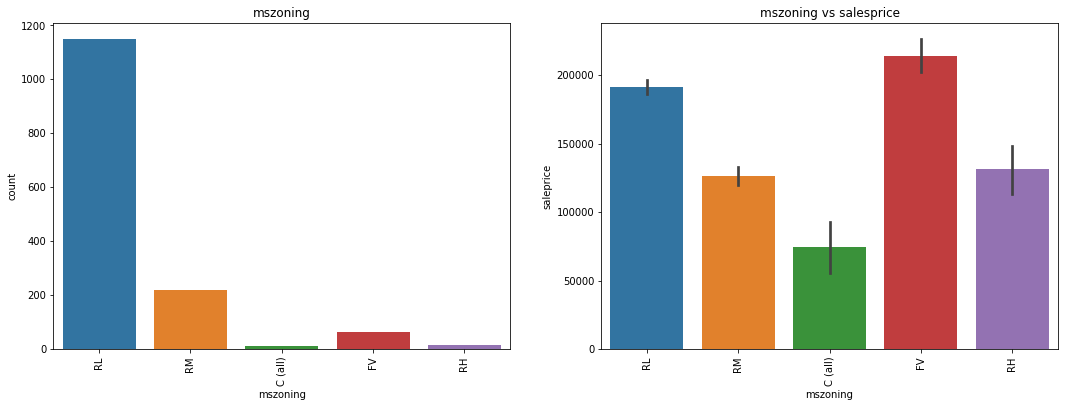

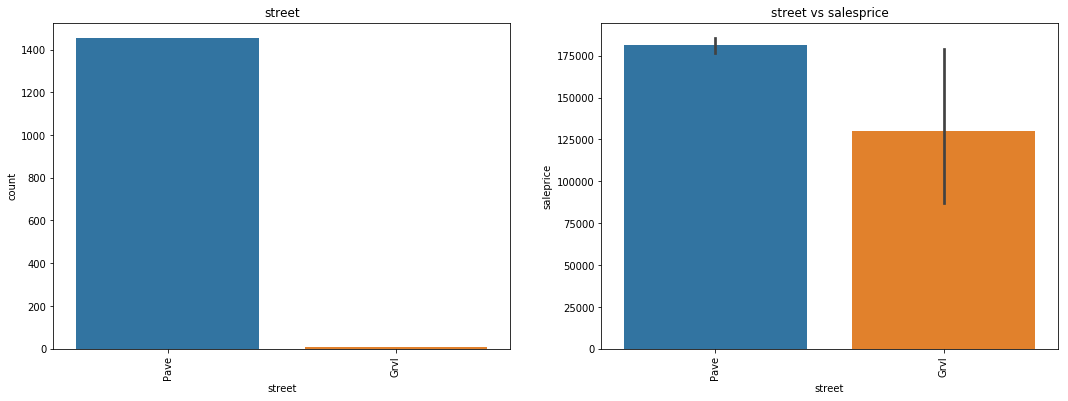

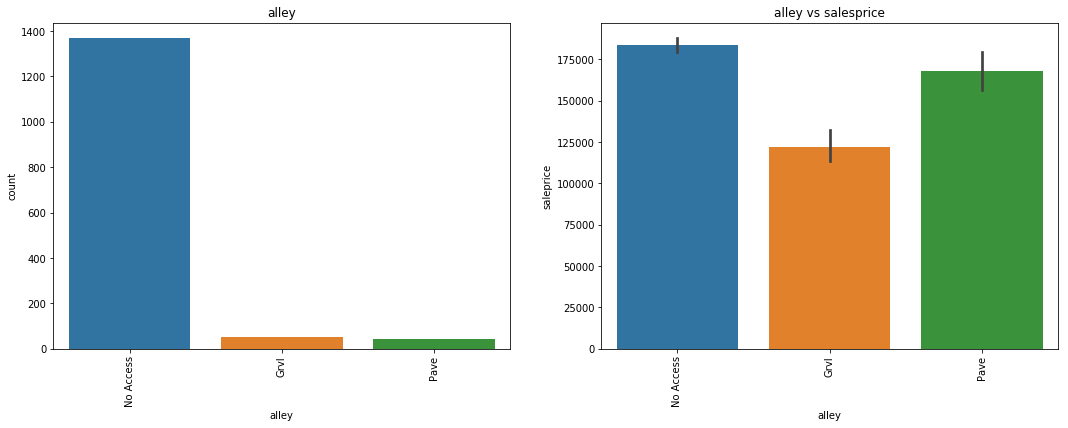

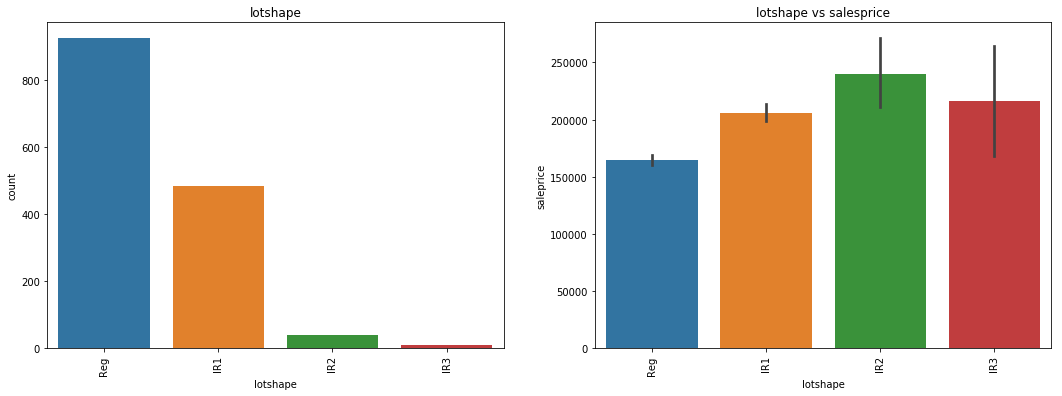

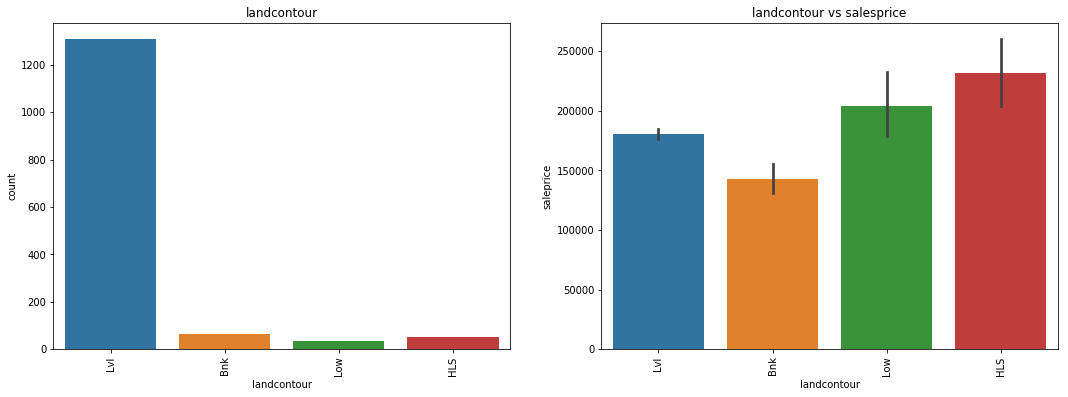

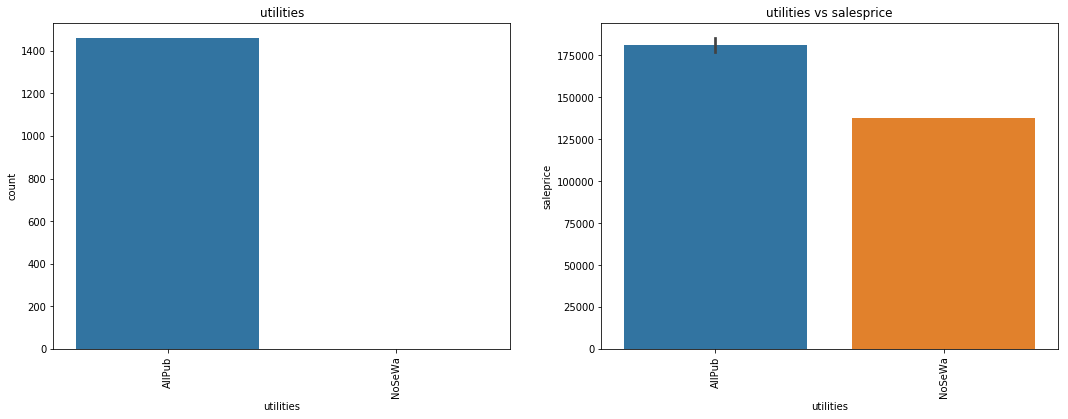

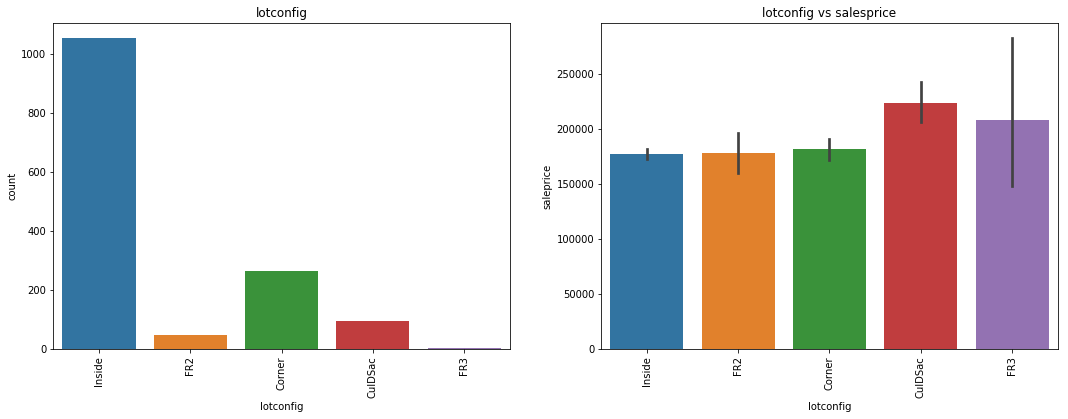

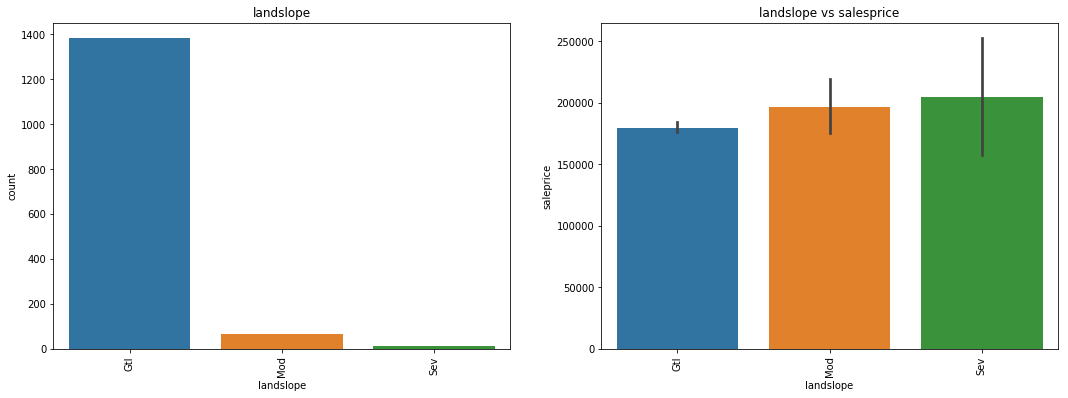

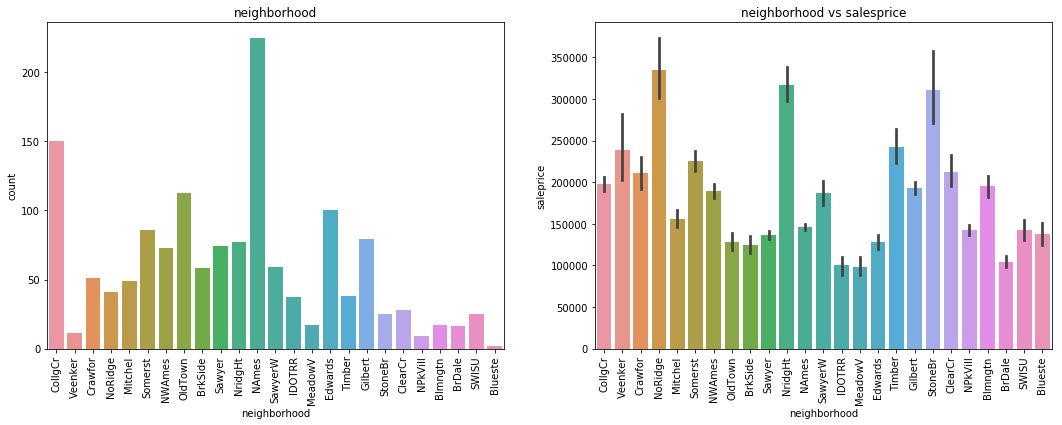

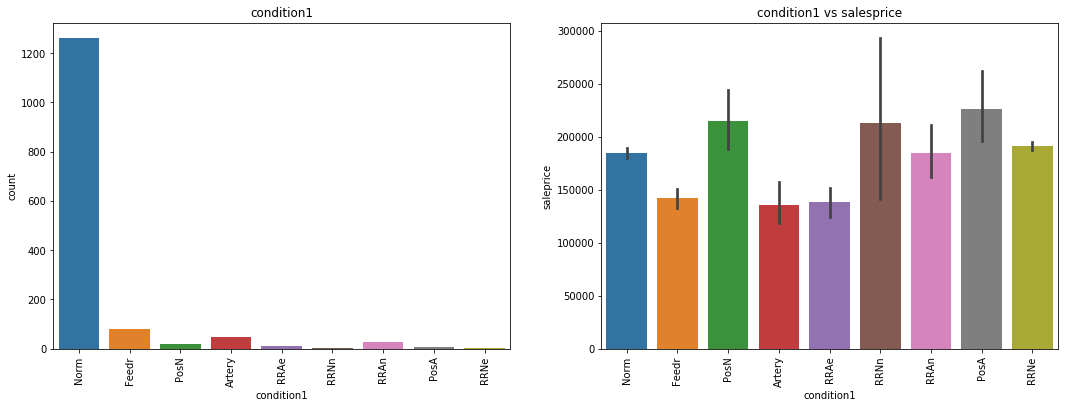

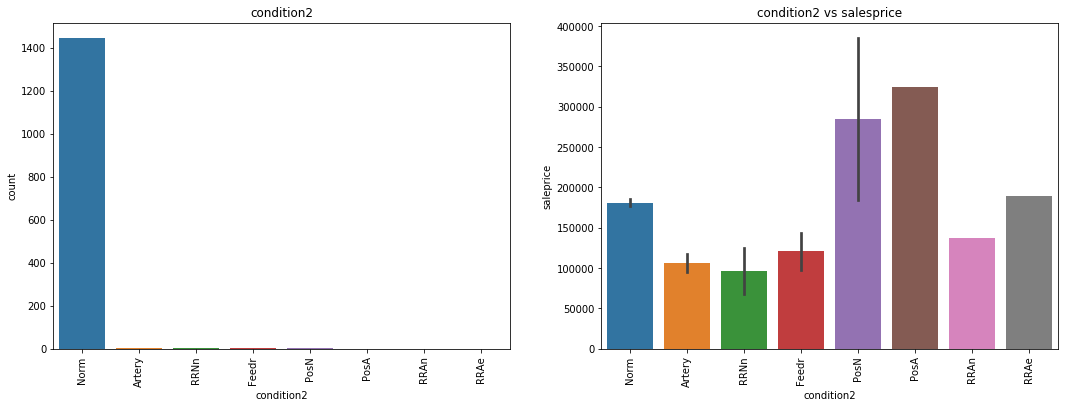

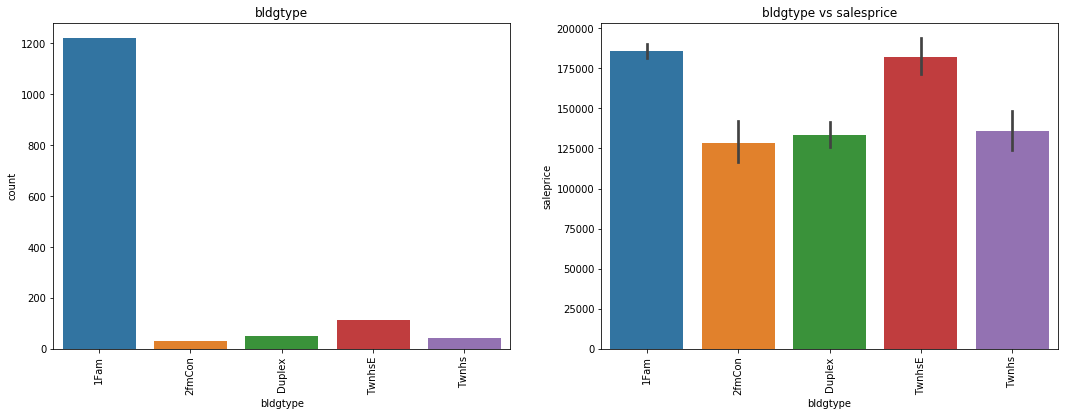

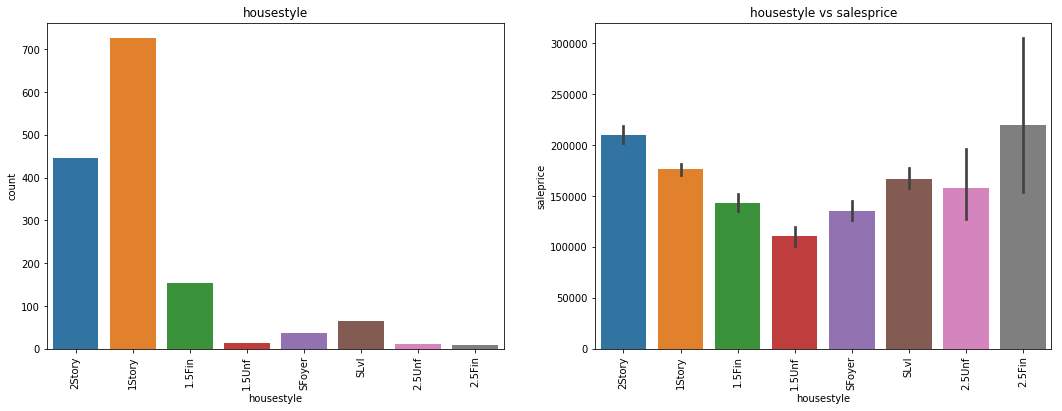

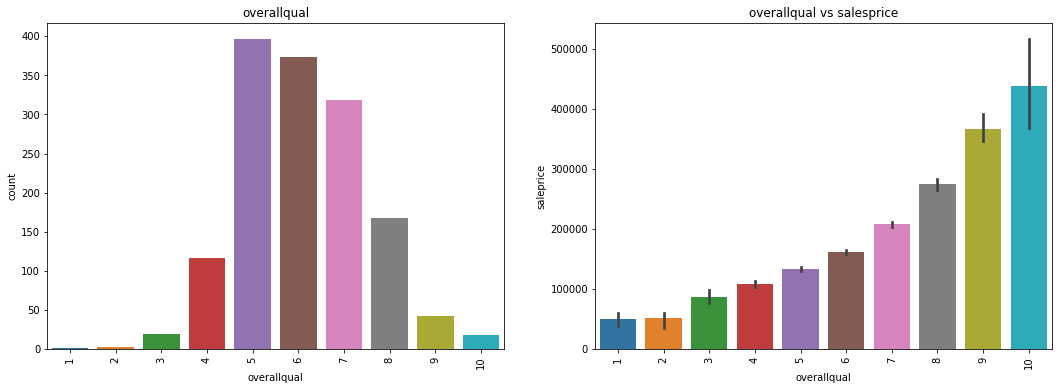

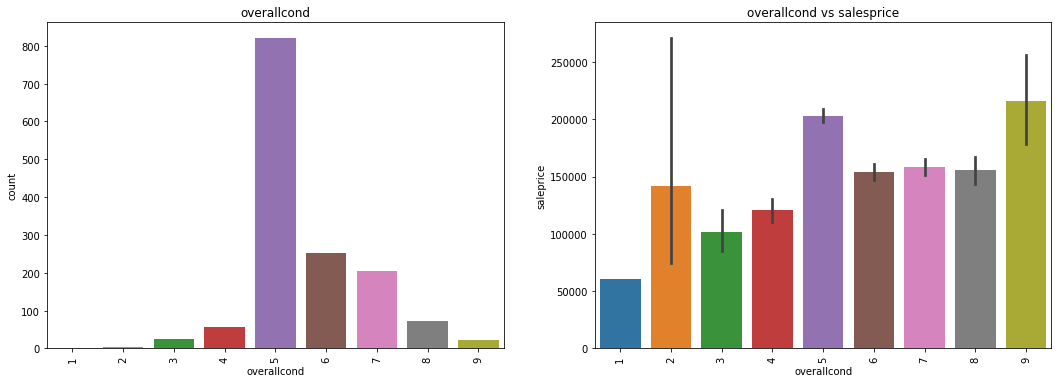

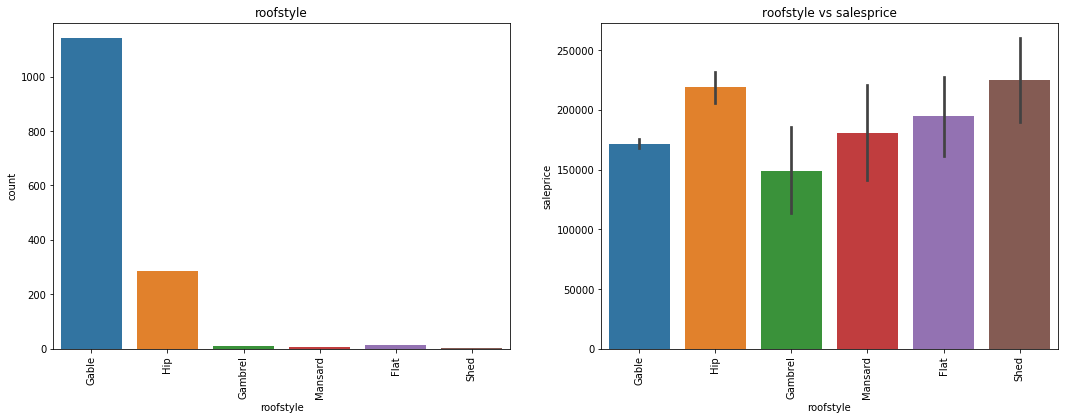

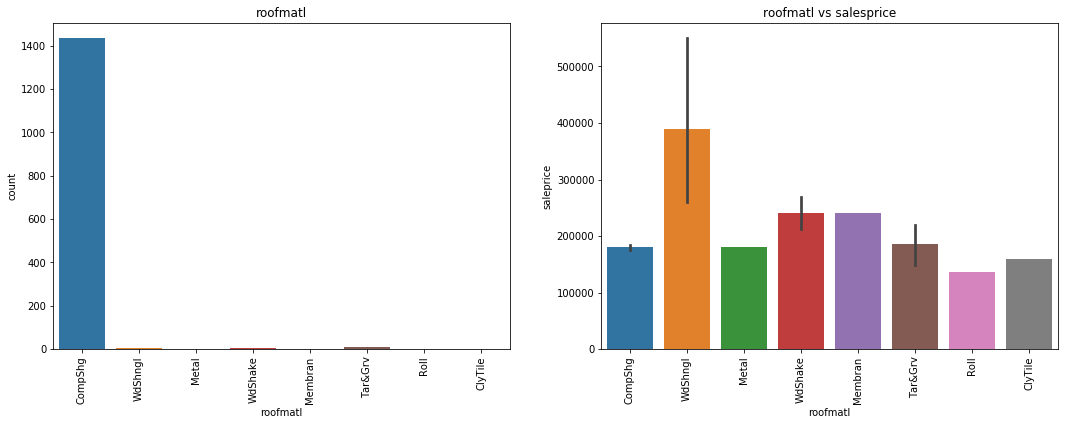

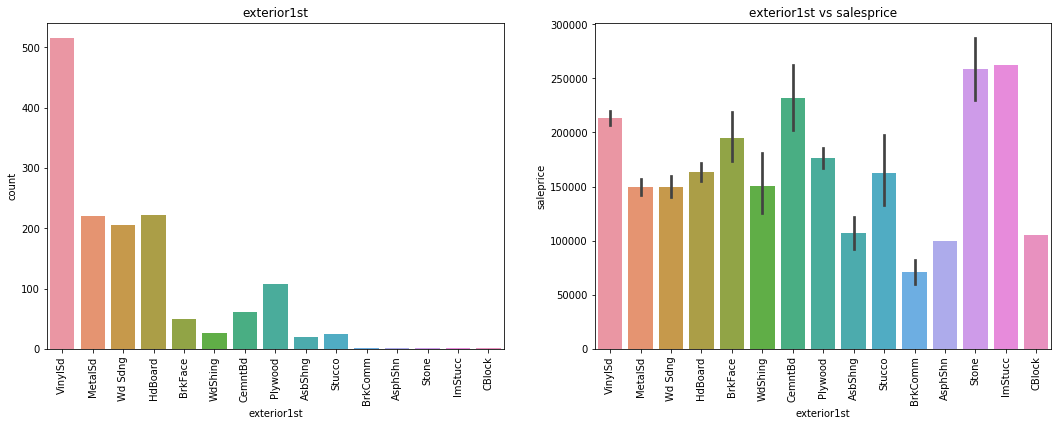

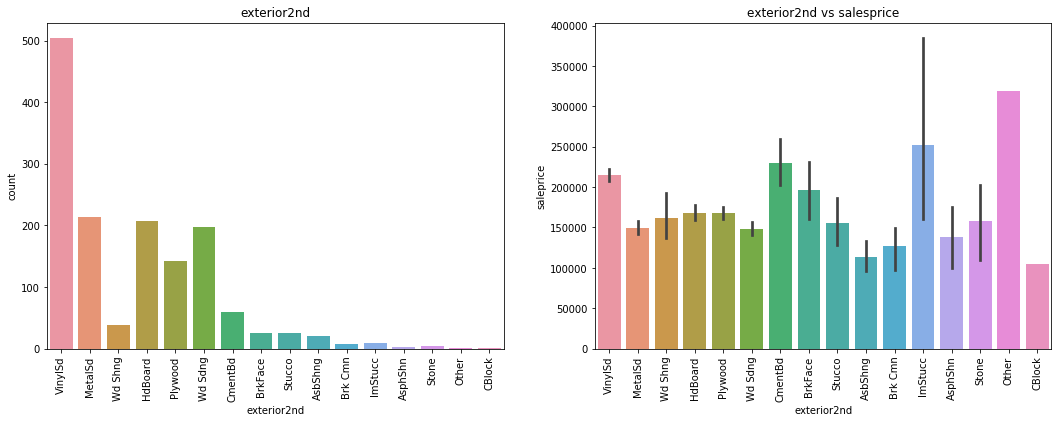

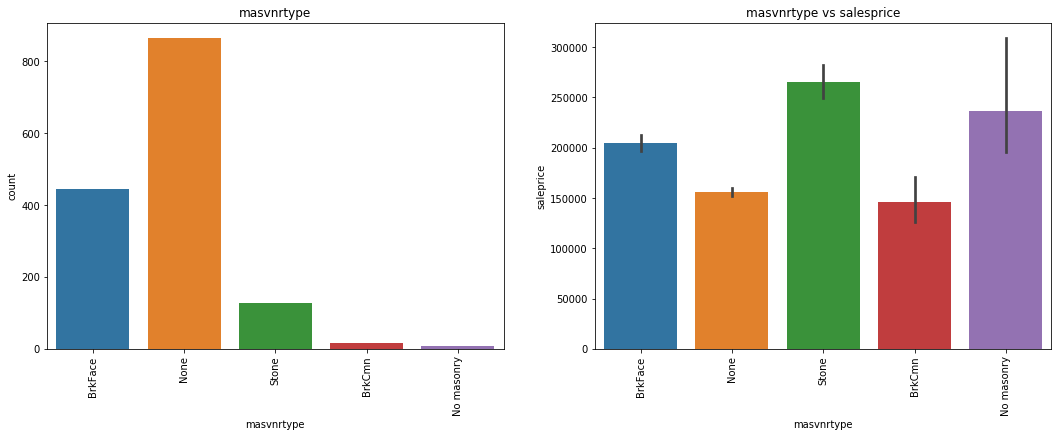

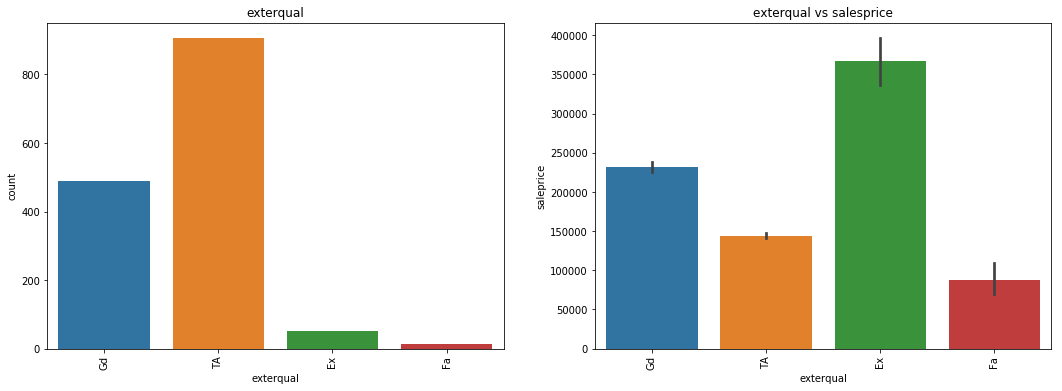

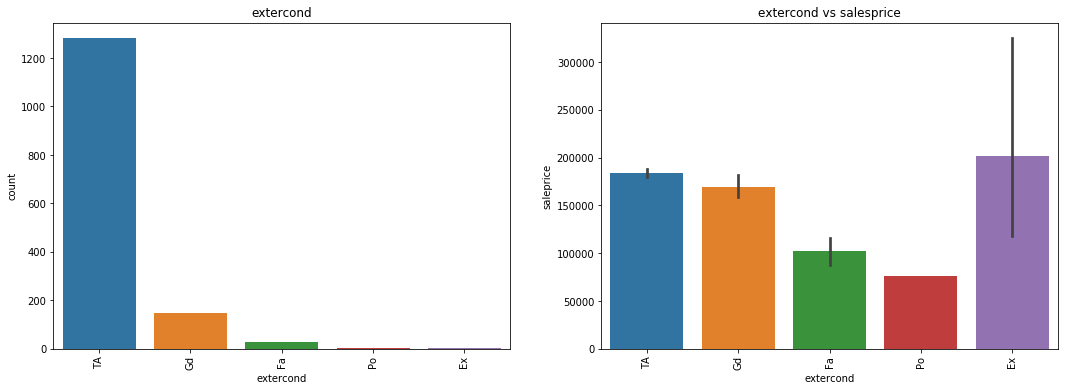

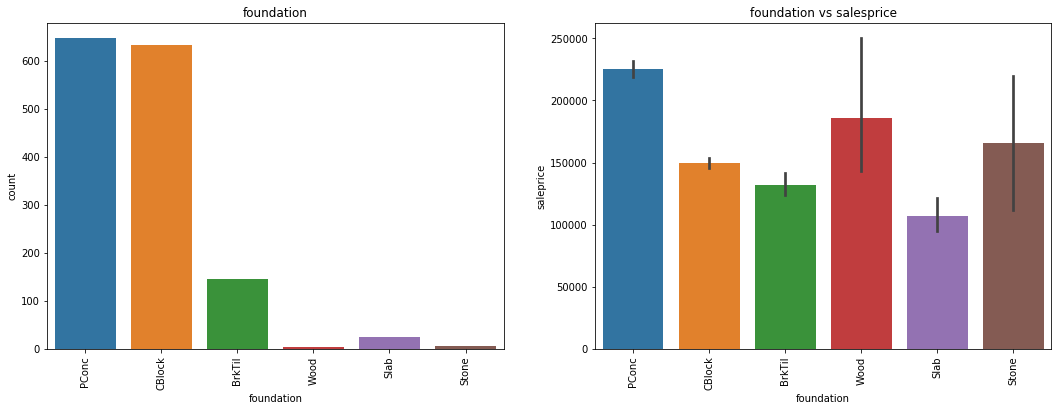

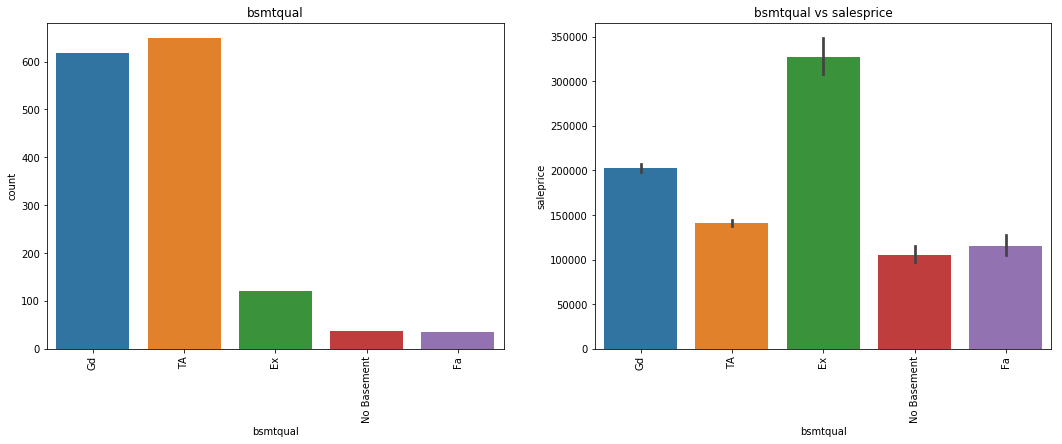

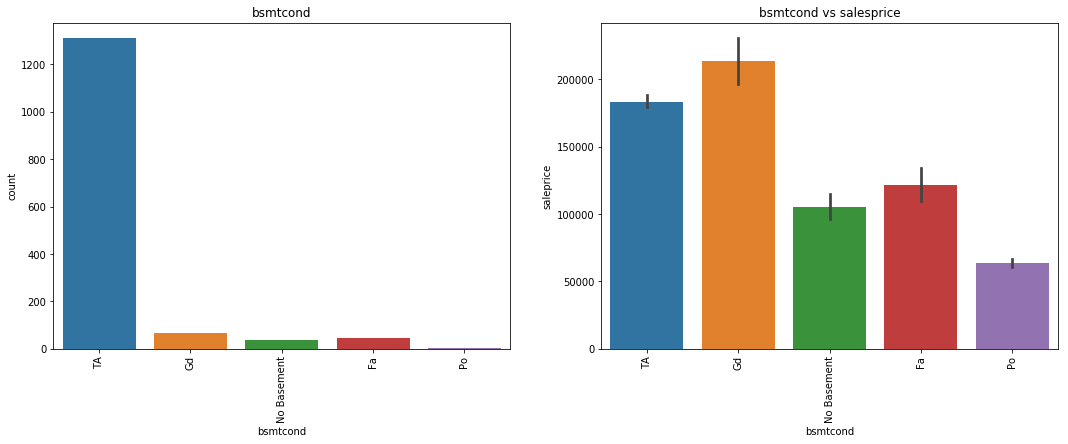

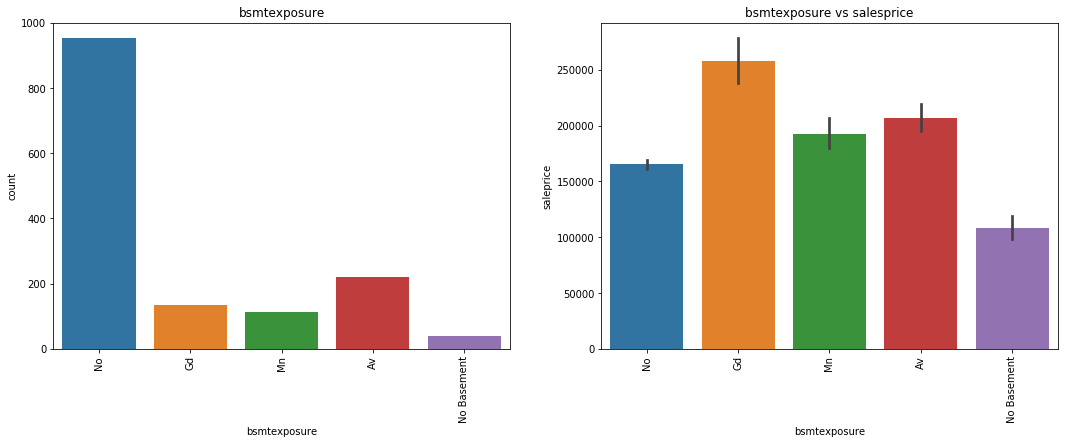

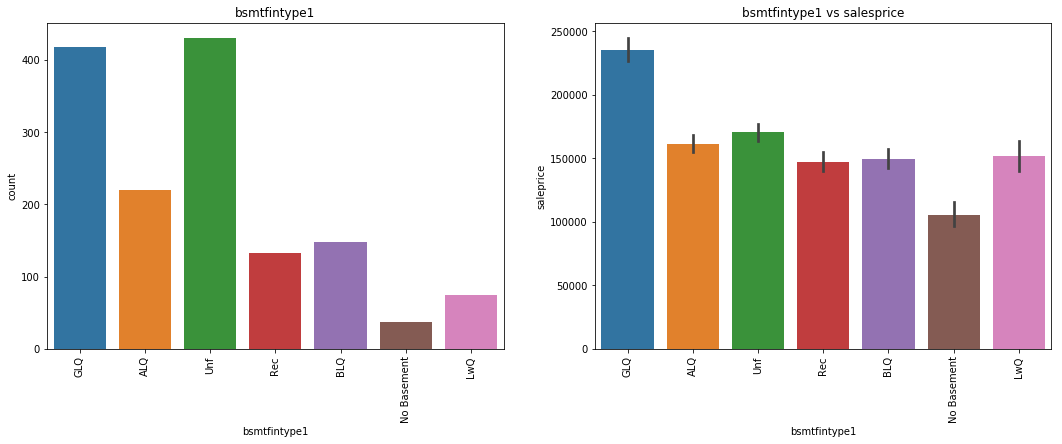

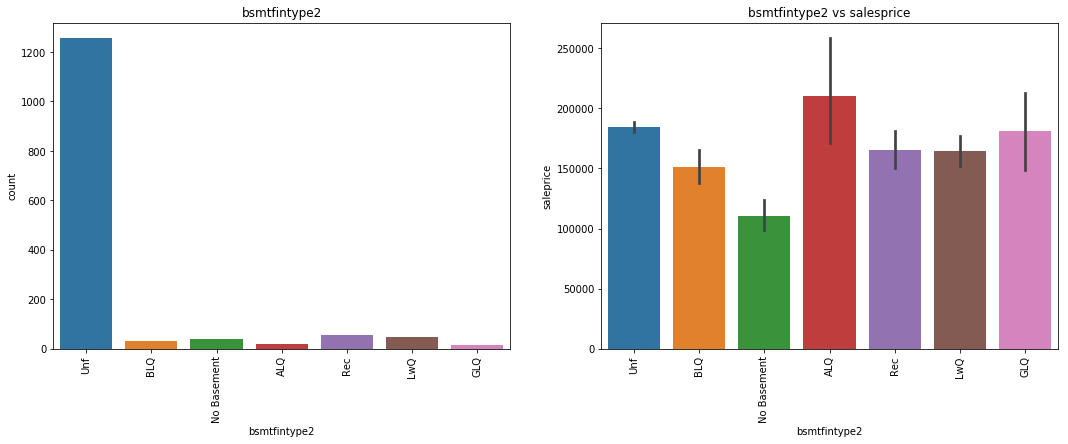

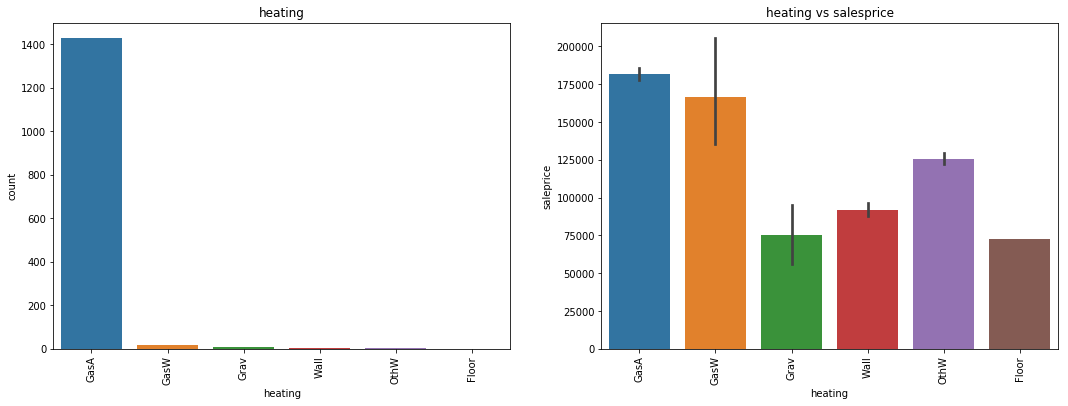

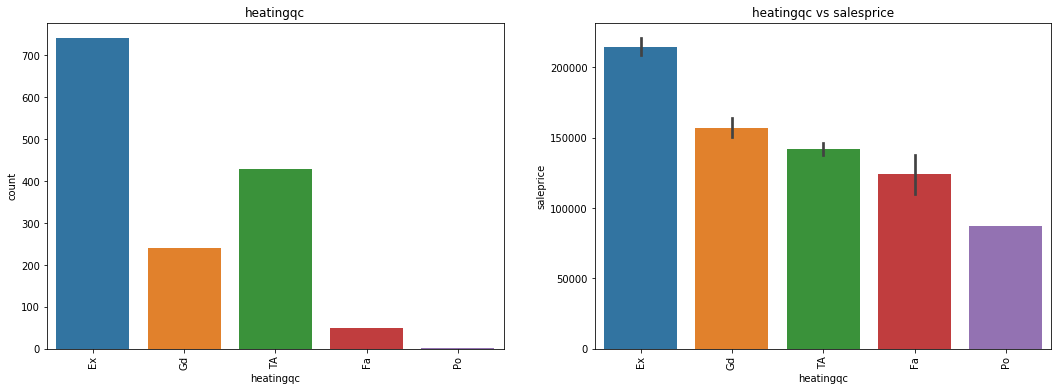

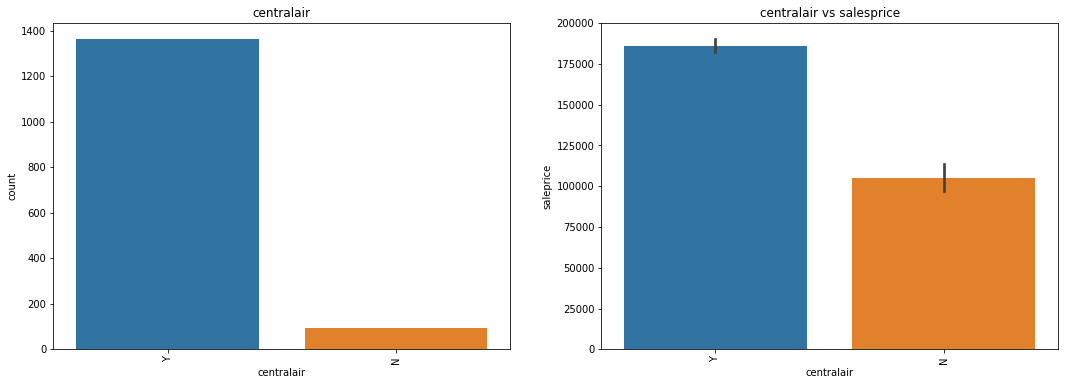

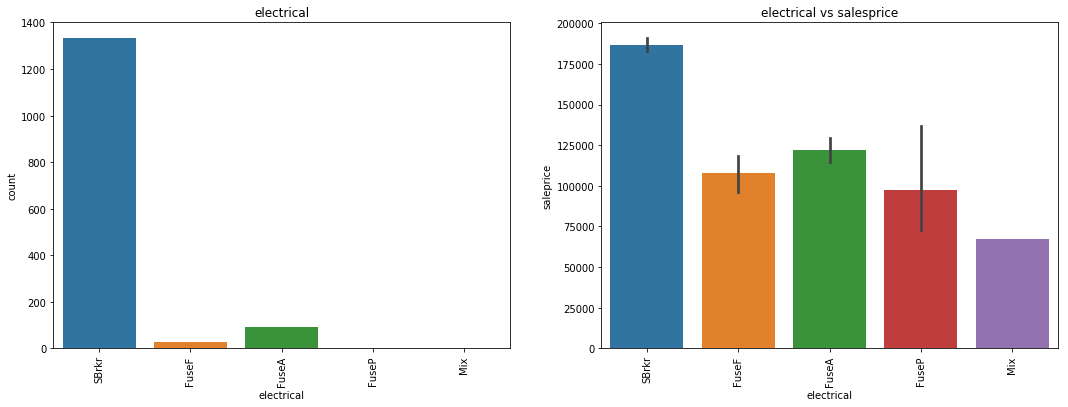

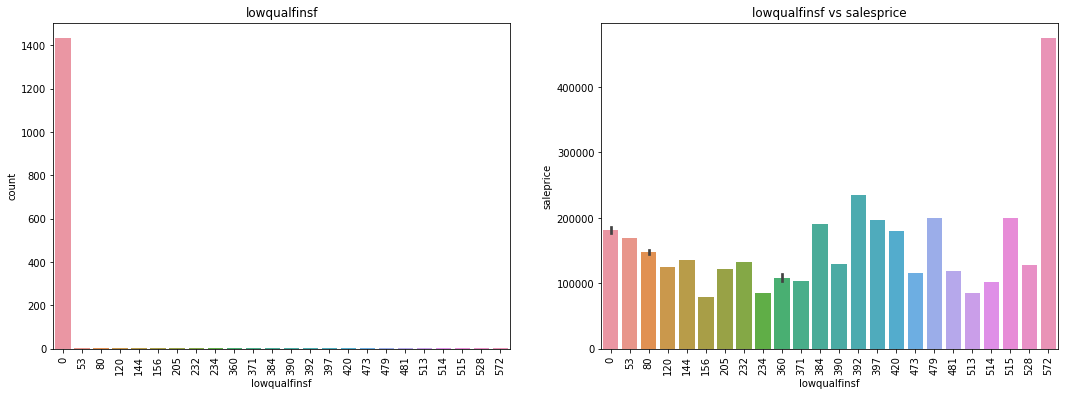

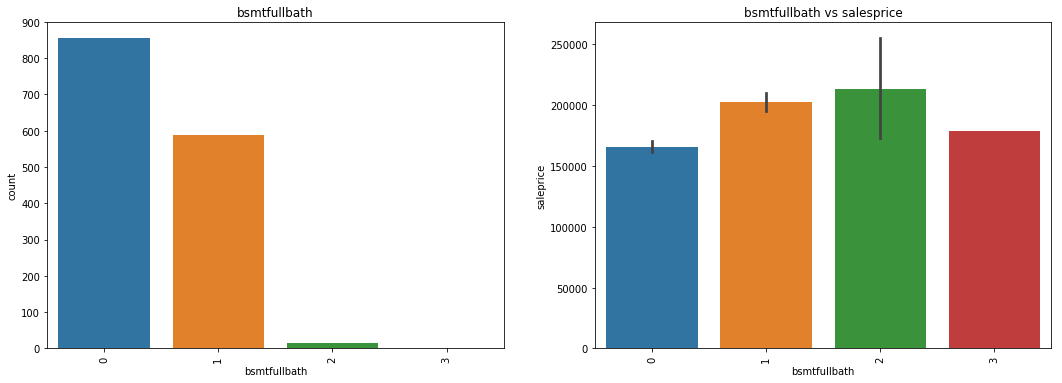

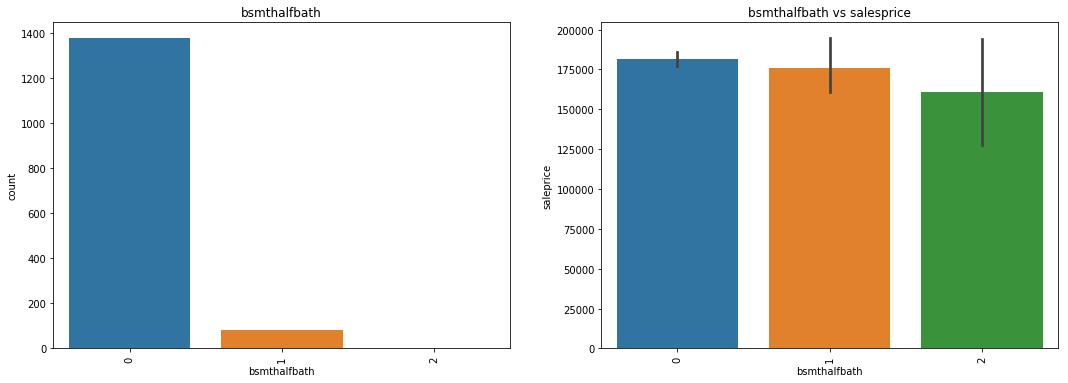

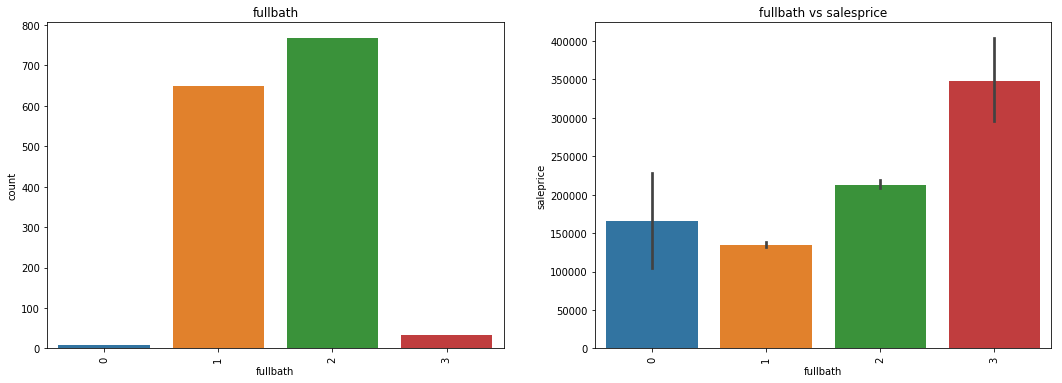

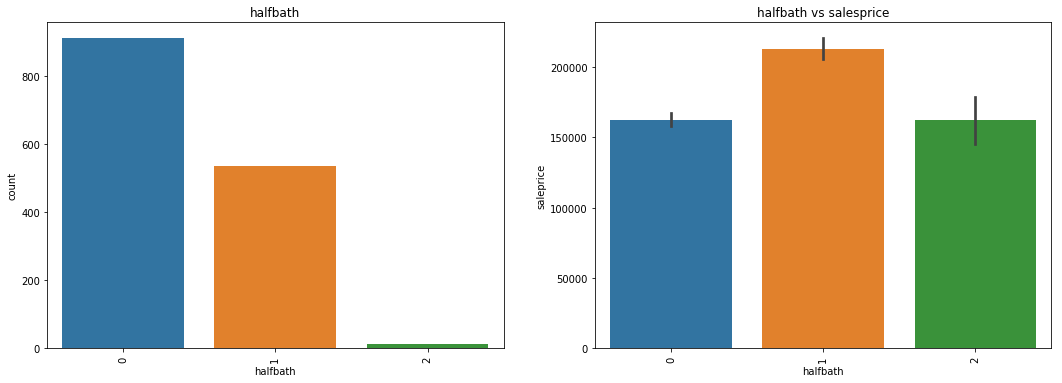

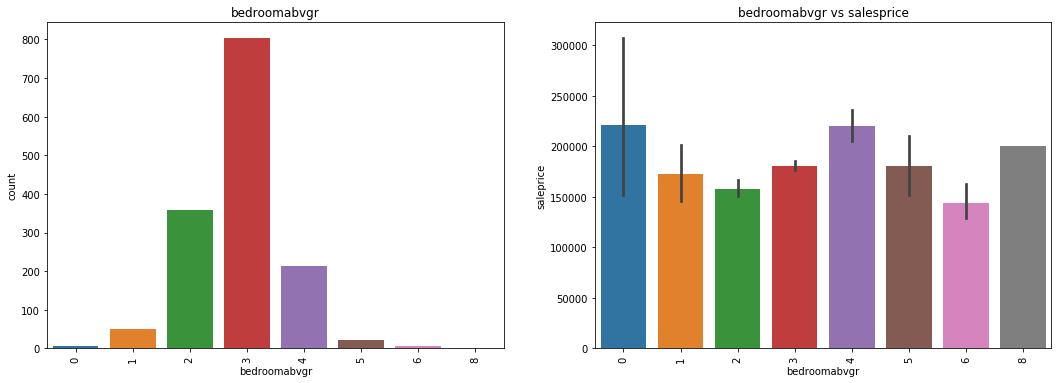

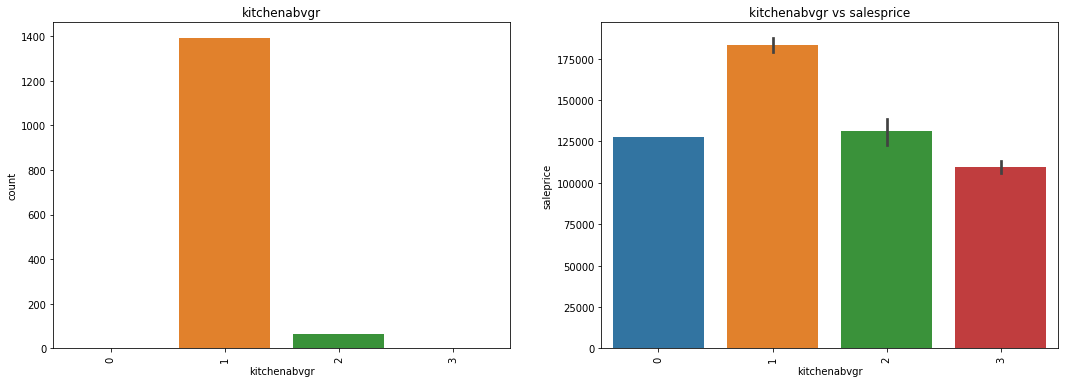

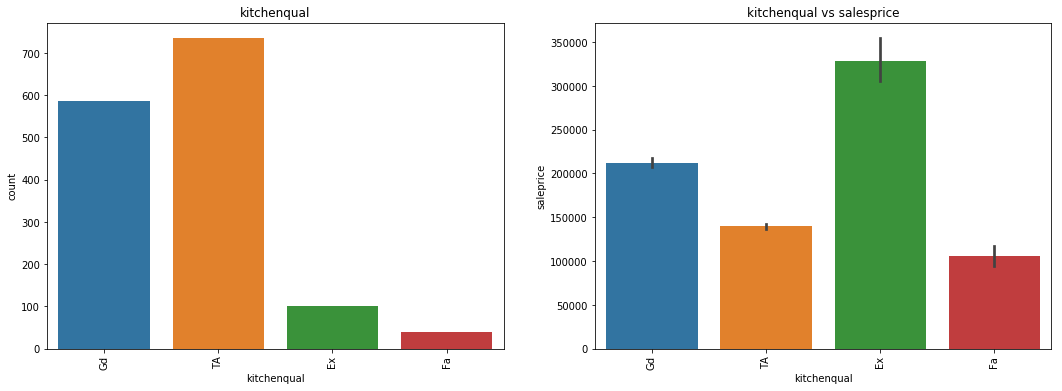

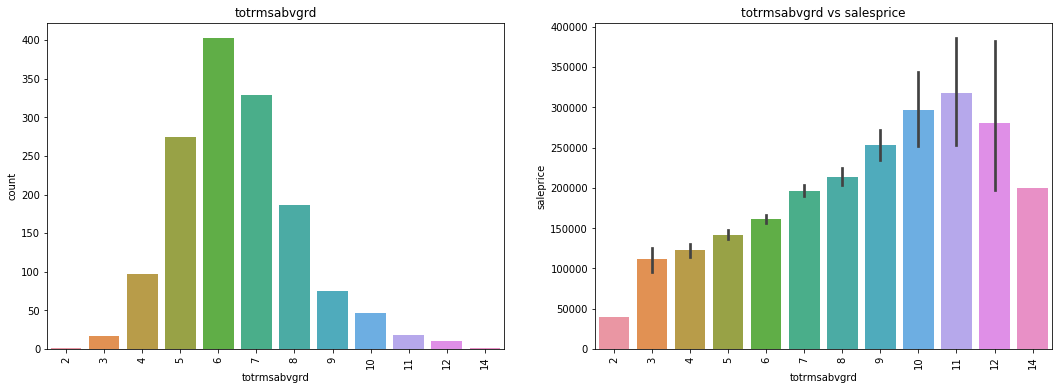

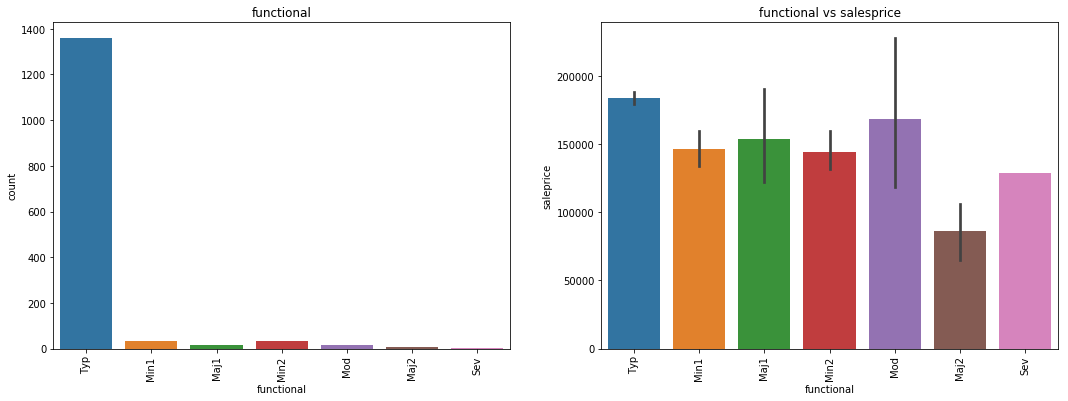

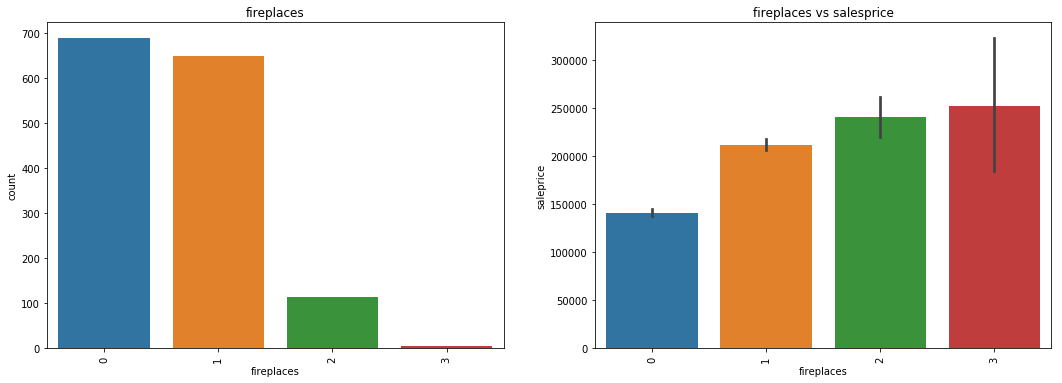

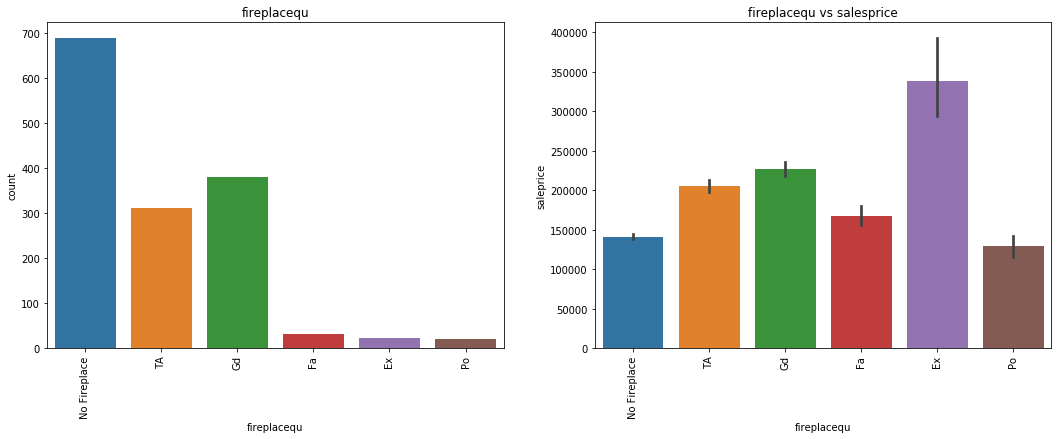

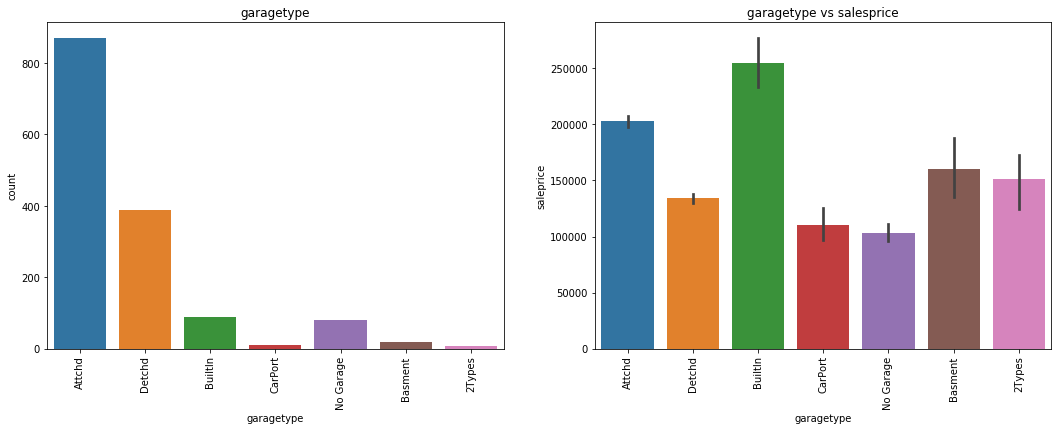

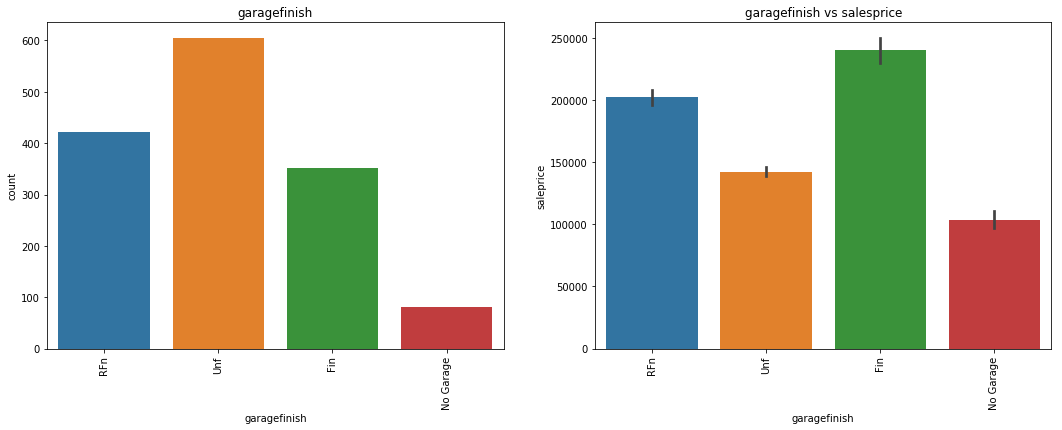

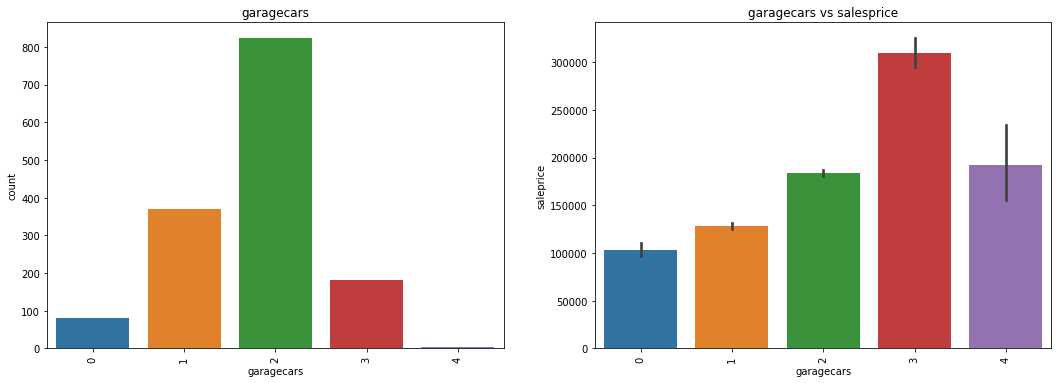

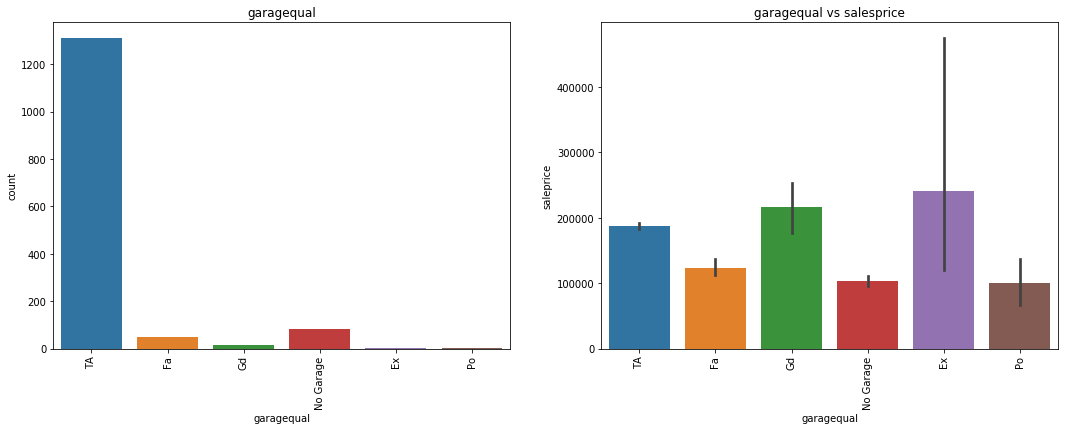

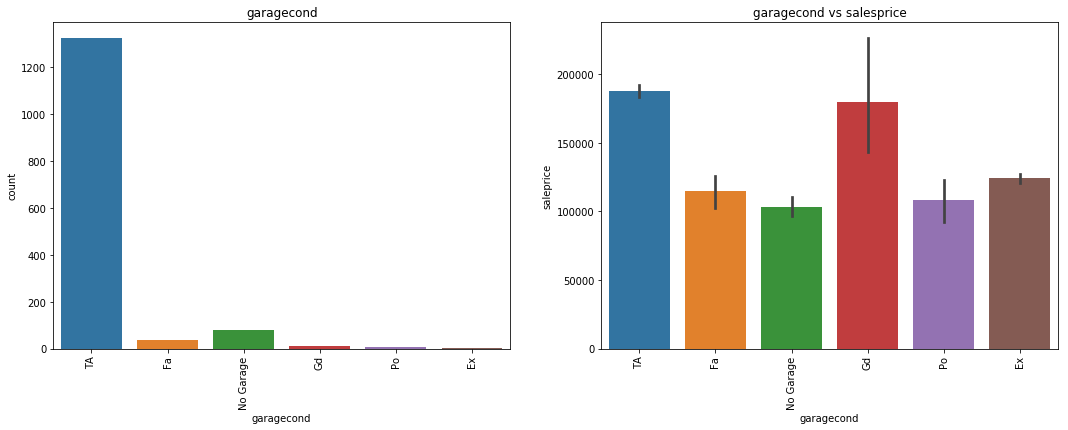

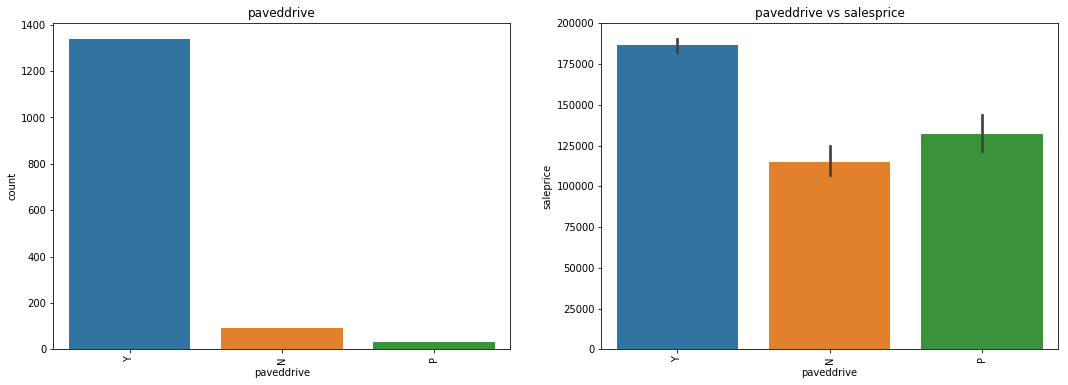

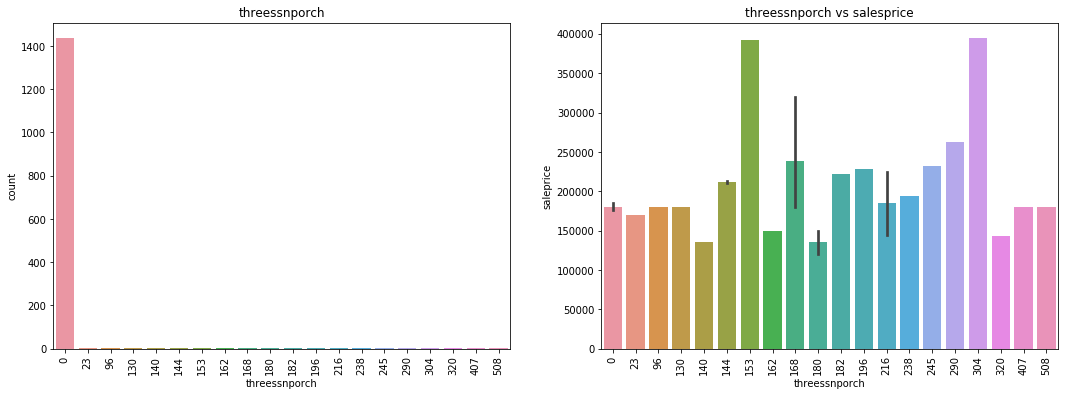

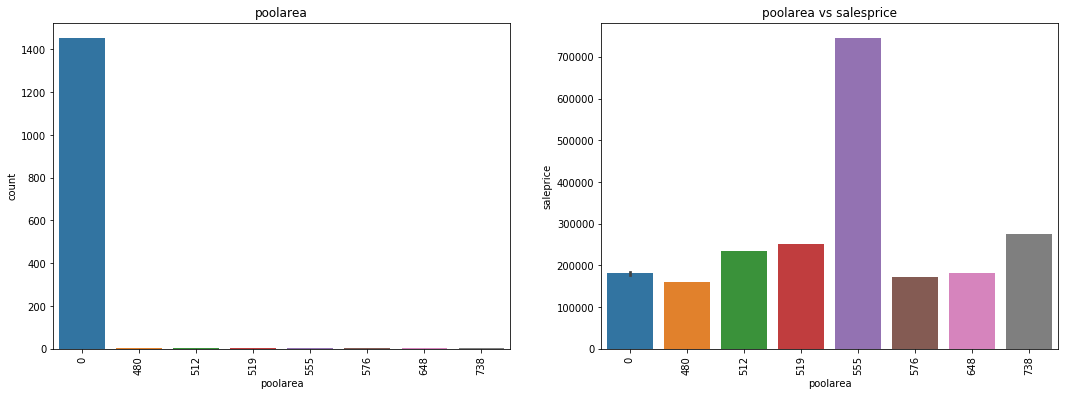

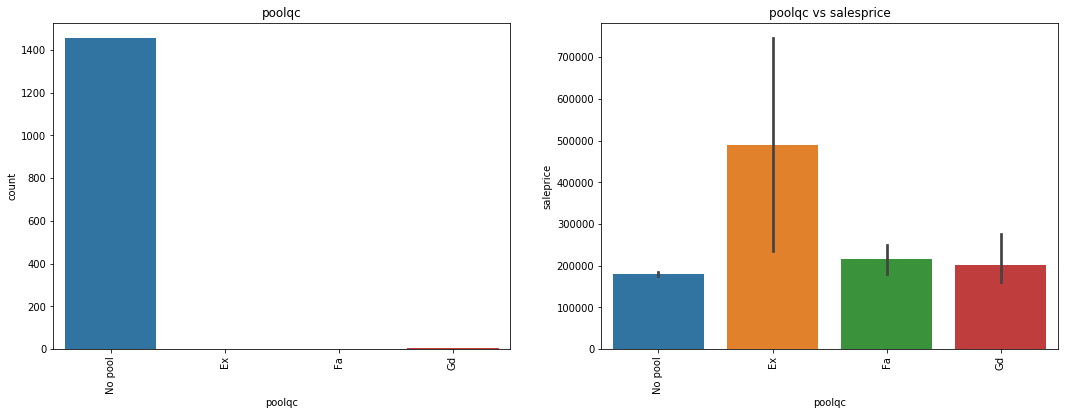

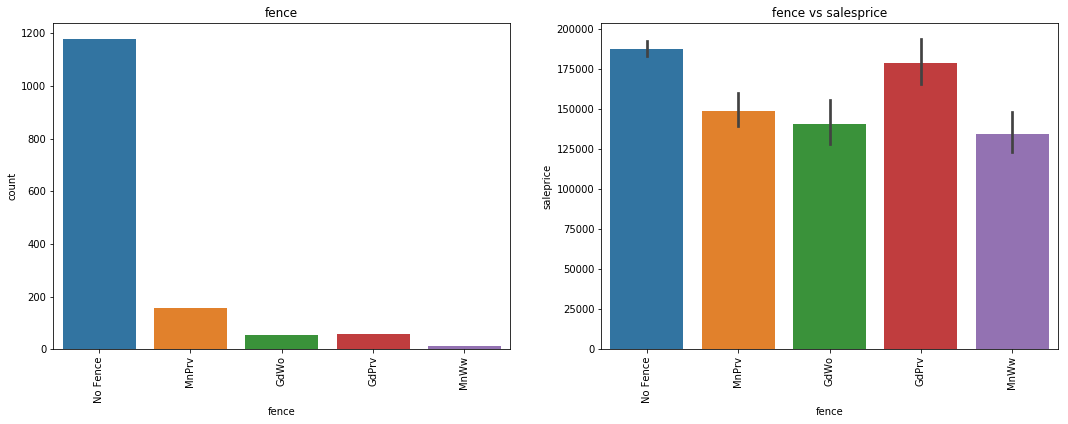

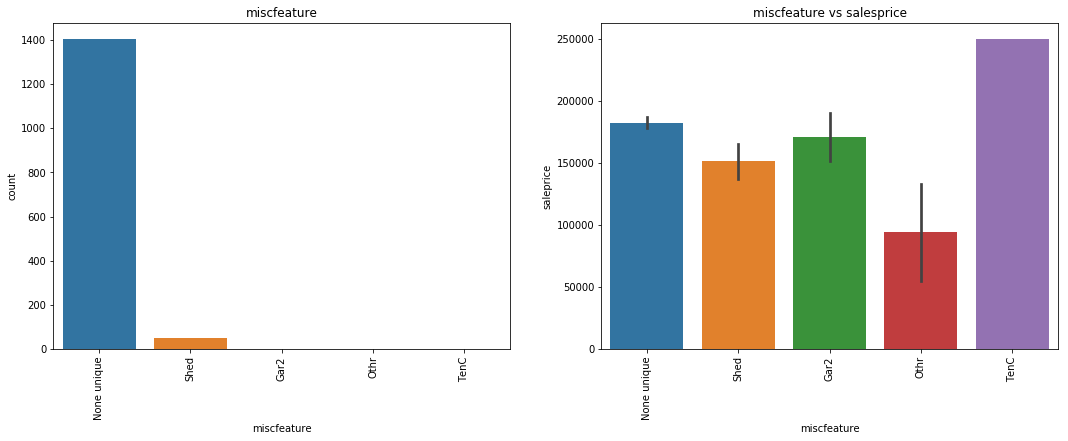

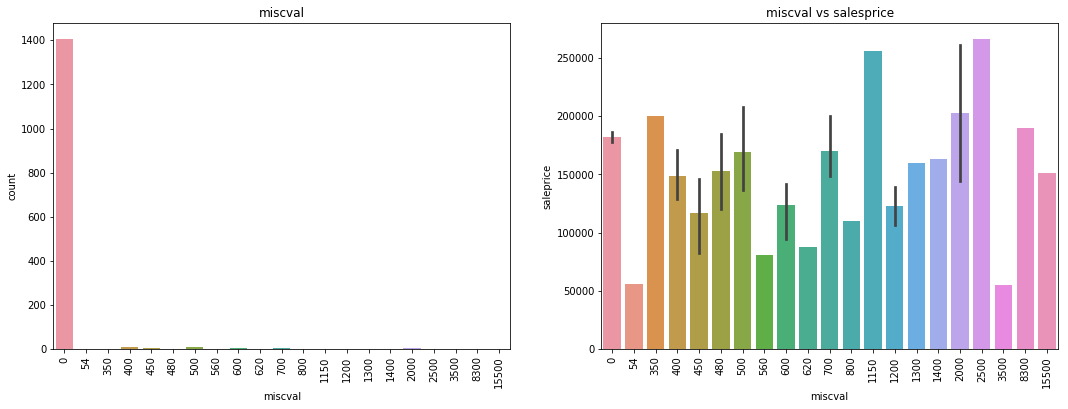

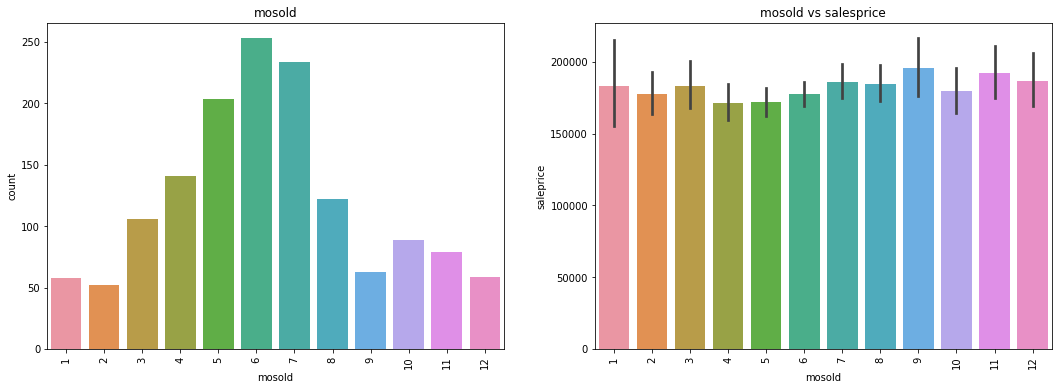

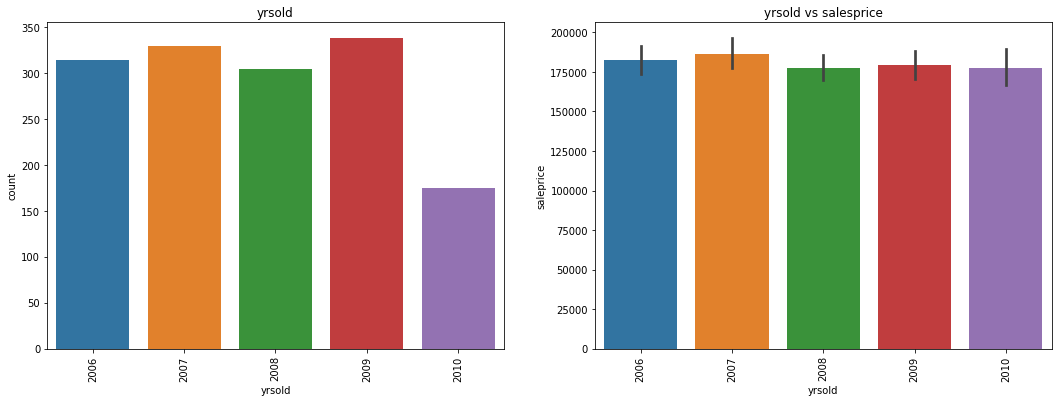

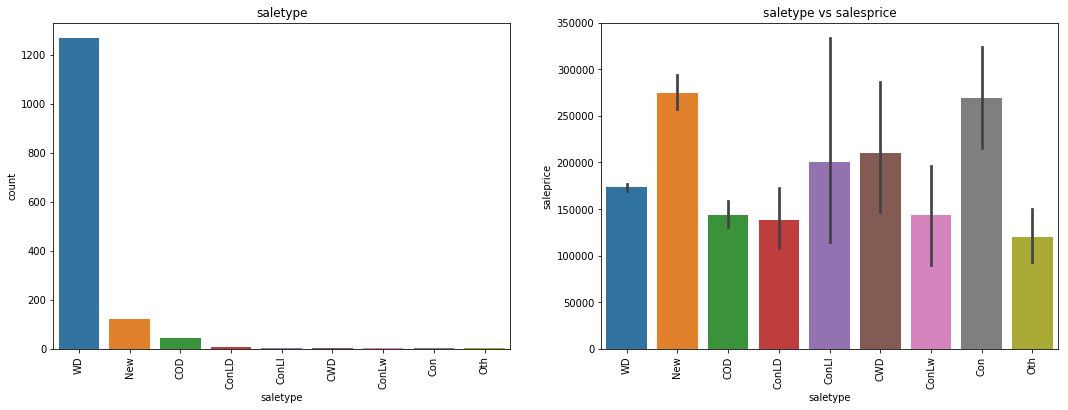

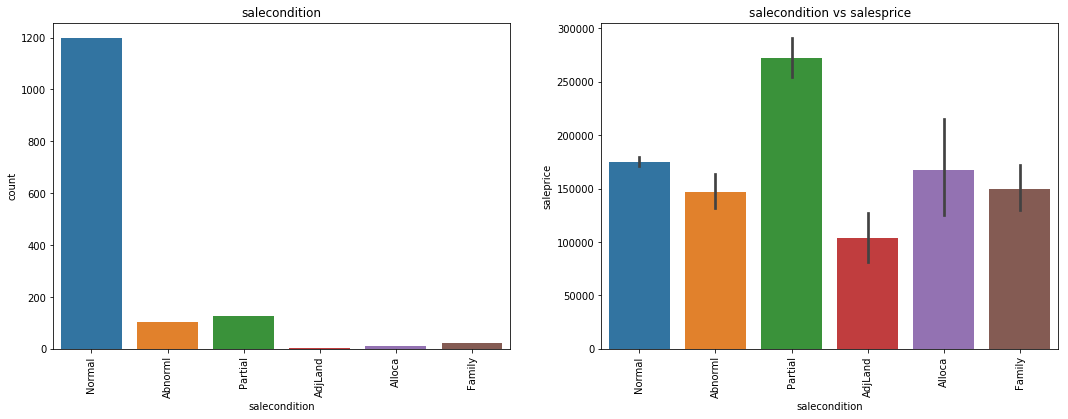

In [10]:
#let's inspect our categorical values
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.title('{}'.format(column))
    plt.xticks(rotation='vertical')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='saleprice', data=df)
    plt.title('{} vs salesprice'.format(column))
    plt.xticks(rotation='vertical')
    
    plt.show()

The coefficient is 0.33477085313975996


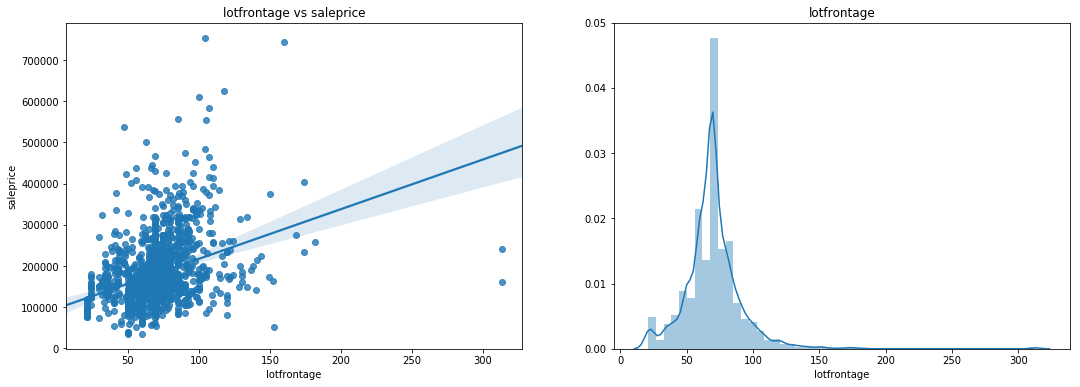

The coefficient is 0.2638433538714056


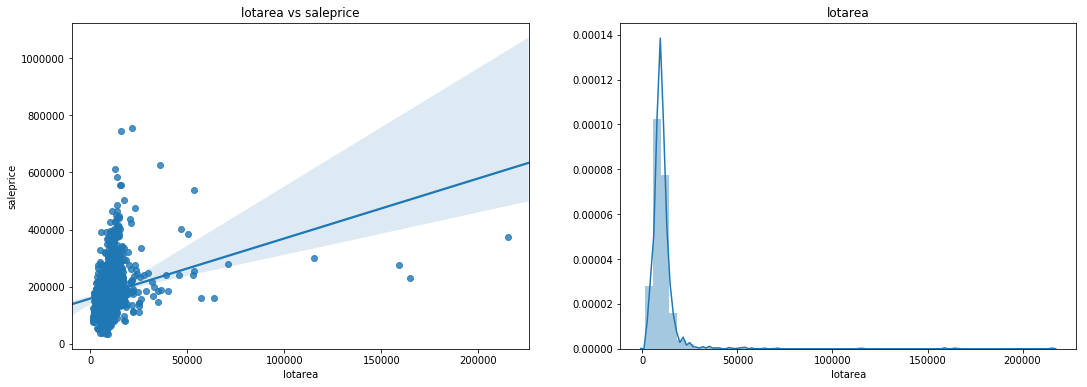

The coefficient is 0.522897332879497


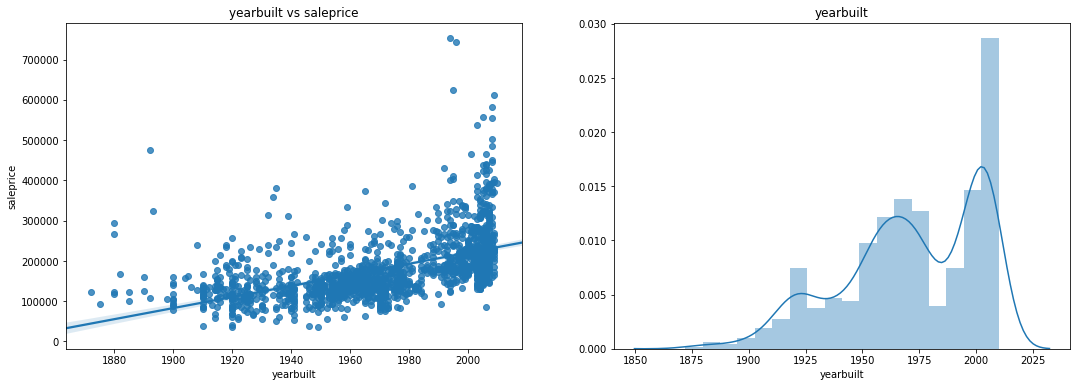

The coefficient is 0.5071009671113861


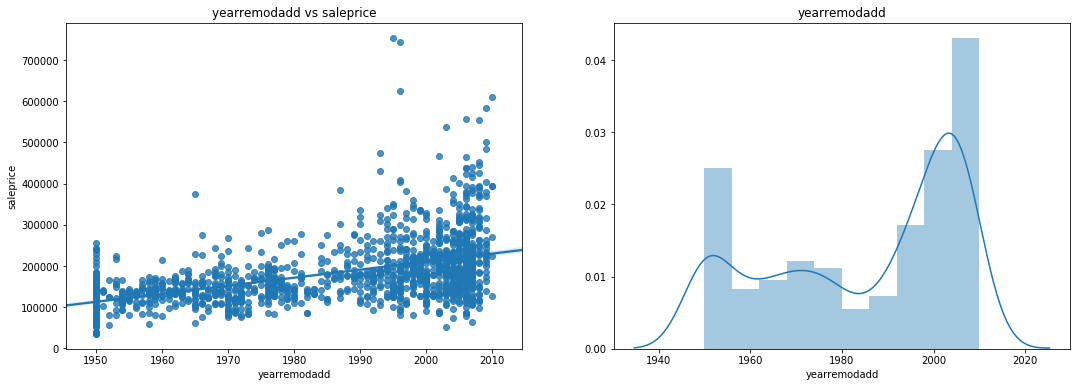

The coefficient is 0.4726144990045737


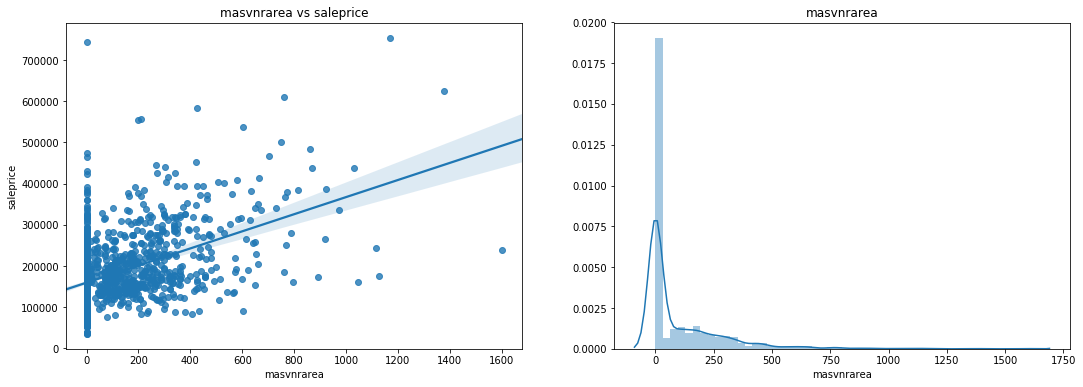

The coefficient is 0.3864198062421533


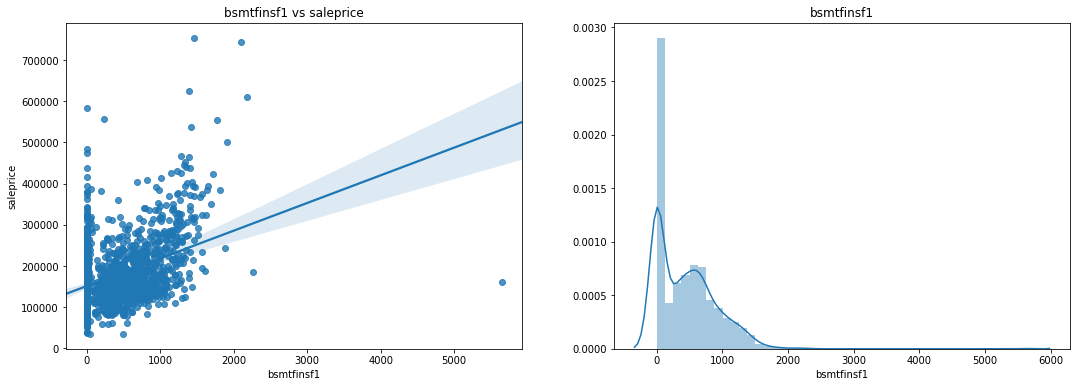

The coefficient is -0.01137812145021514


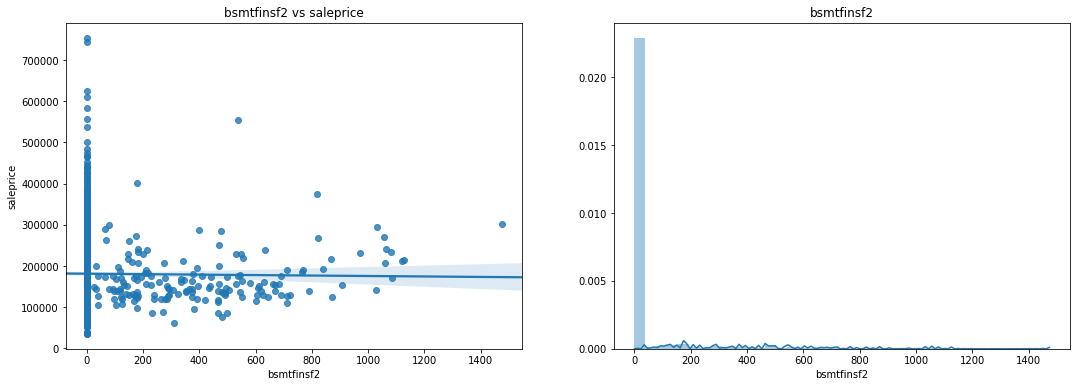

The coefficient is 0.2144791055469689


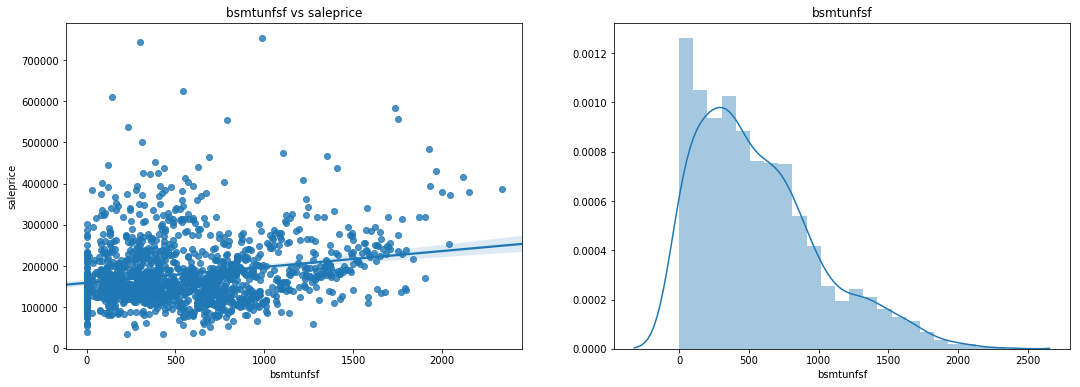

The coefficient is 0.6135805515591953


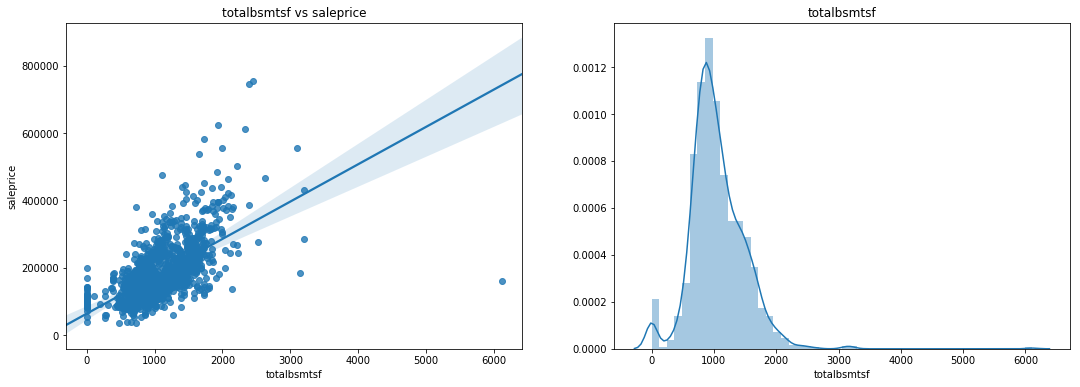

The coefficient is 0.6058521846919147


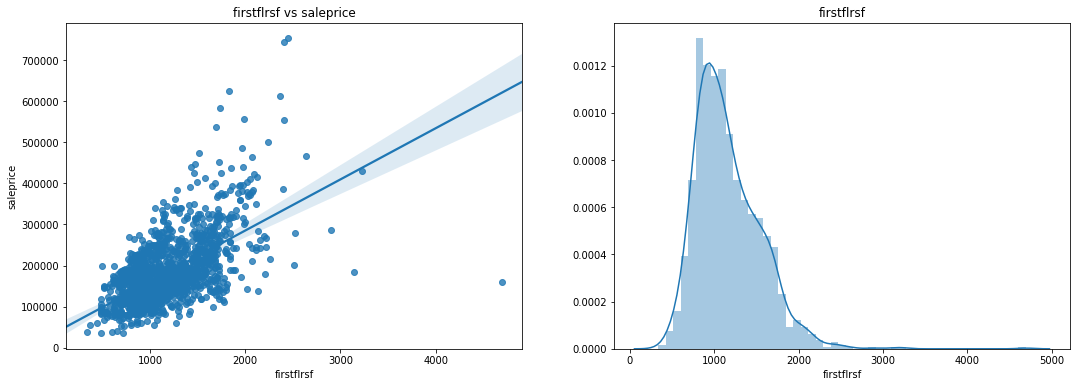

The coefficient is 0.3193338028320678


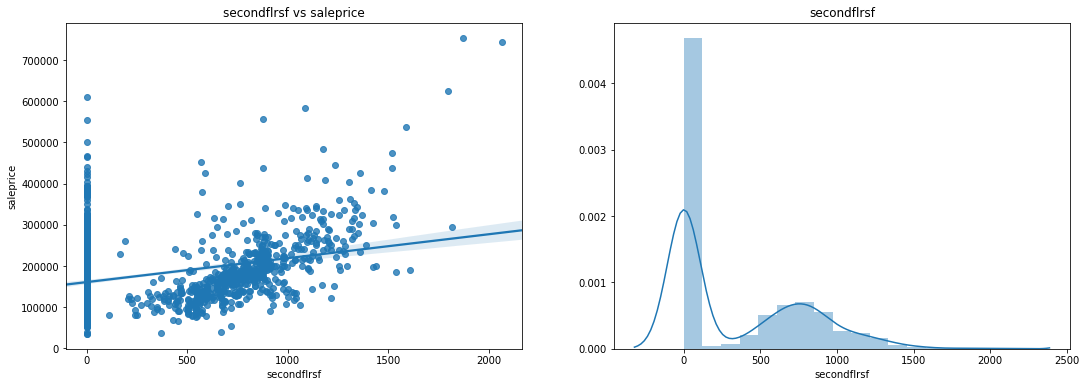

The coefficient is 0.708624477612652


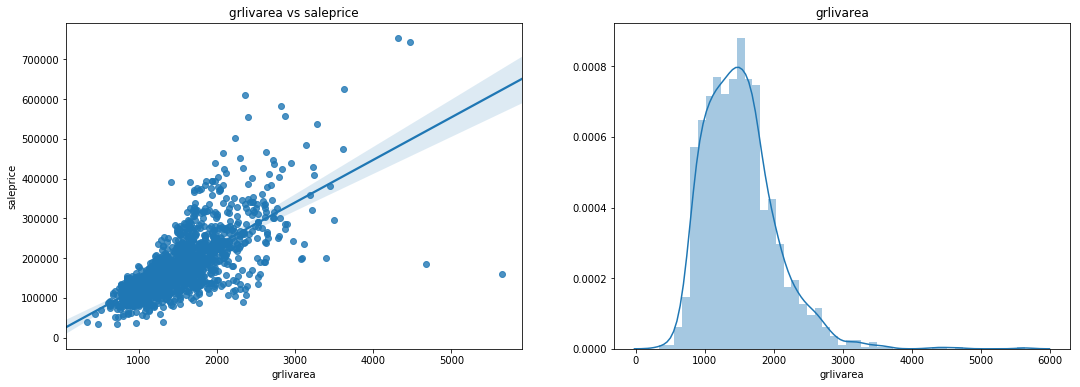

The coefficient is 0.6234314389183616


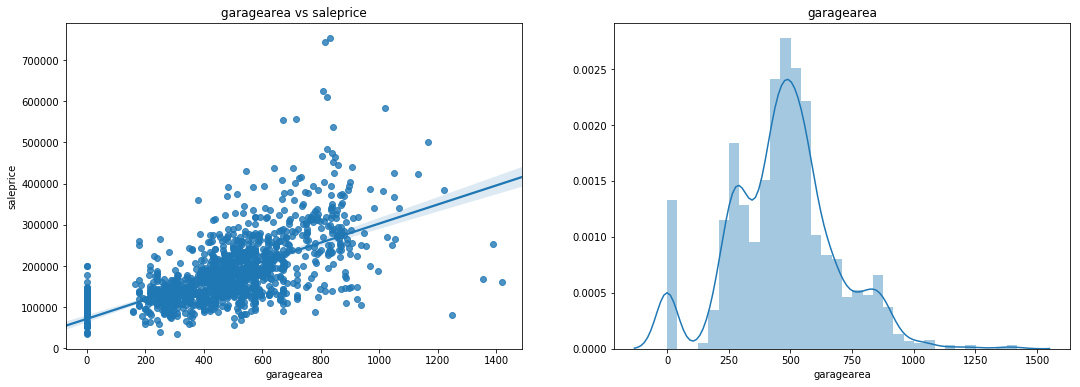

The coefficient is 0.3244134445681299


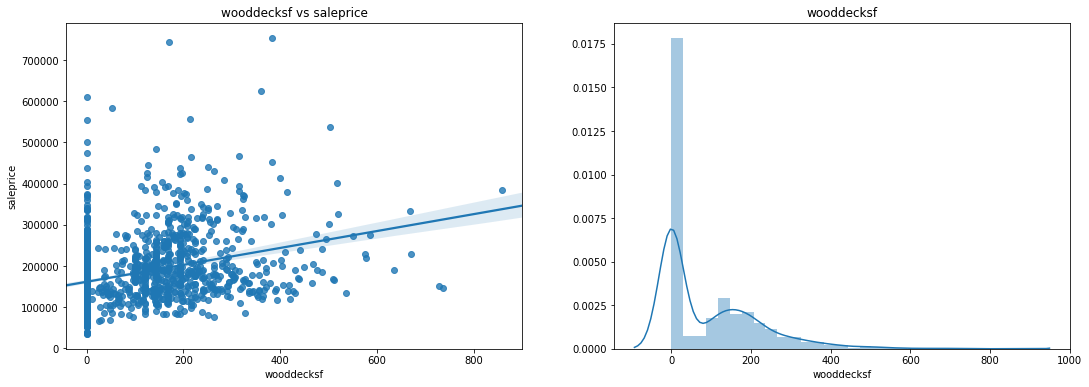

The coefficient is 0.3158562271160552


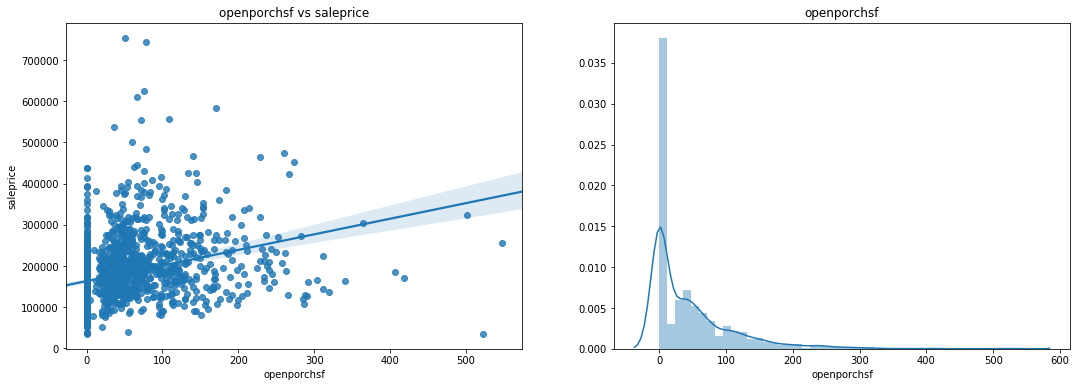

The coefficient is -0.12857795792595675


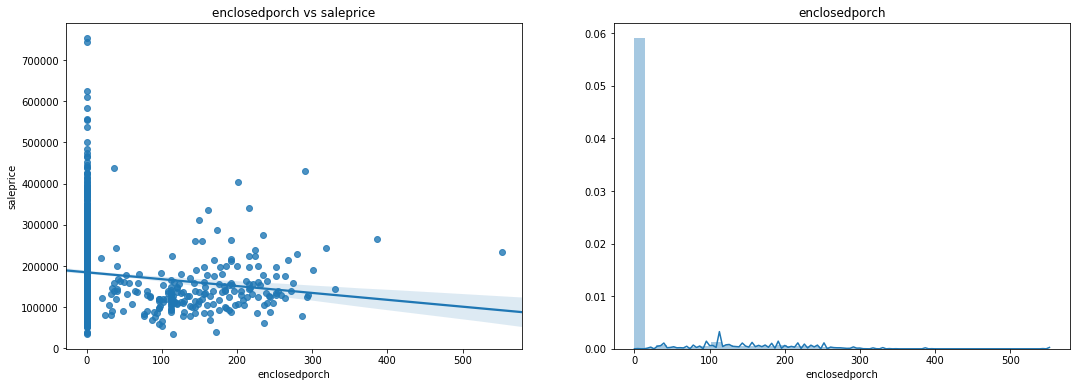

The coefficient is 1.0


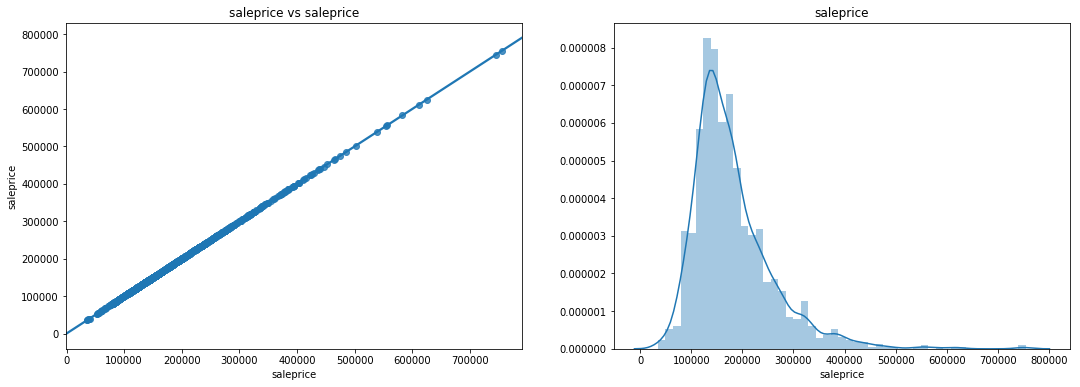

The coefficient is 0.11144657114291123


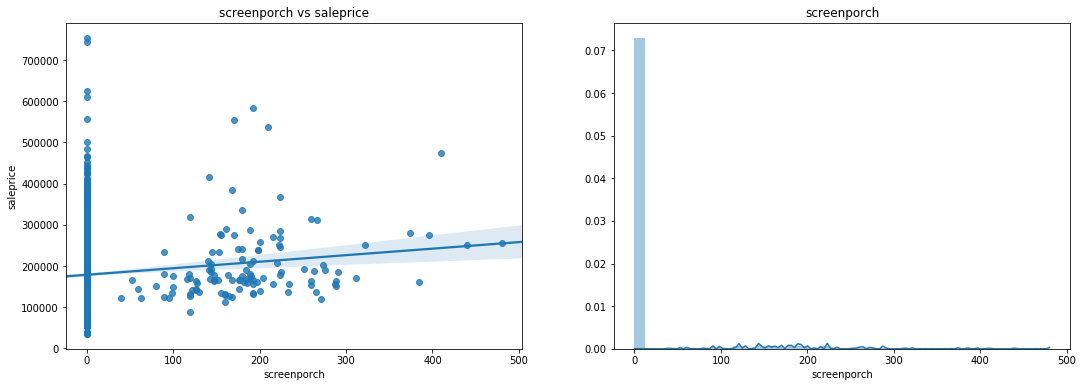

In [11]:
for column in cont_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    corr, p_value = stats.pearsonr(df['saleprice'], df[column])
    print('The coefficient is {}'.format(corr))
    sns.regplot(x=column, y='saleprice', data=df)
    plt.title('{} vs saleprice'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    
    plt.show()

In [12]:
#create our continuous dataframe
cont_df = df[['totalbsmtsf', 'firstflrsf', 'grlivarea', 'garagearea', 'saleprice']]

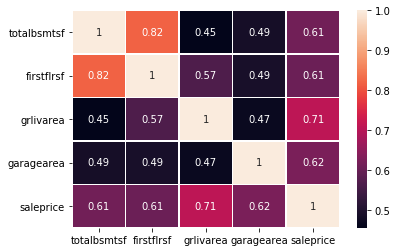

In [13]:
sns.heatmap(cont_df.corr(), annot=True, linewidth=0.5)
plt.show()

In [14]:
#drop firstflrsf
cont_df = cont_df.drop(columns=['firstflrsf', 'garagearea'])

In [15]:
#we only have 1 cat_df that needs get_dummies
dummies = pd.get_dummies(df['kitchenqual'], drop_first=True)
#create our categorical df
cat_df = pd.concat([dummies, df.overallqual, df.totrmsabvgrd, df.fireplaces, df.garagecars], axis=1)

In [16]:
#combine the 2 dataframes
final_df = pd.concat([cont_df, cat_df], axis=1)

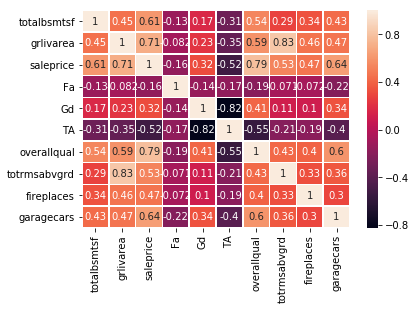

In [17]:
sns.heatmap(final_df.corr(), annot=True, linewidth=0.5)
plt.show()

Those look pretty good, let's start building our OLS lr model!

In [18]:
X = final_df.drop(columns='saleprice')
y = final_df['saleprice']

In [19]:
lrm = linear_model.LinearRegression()

lrm.fit(X, y)

print('Coefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

Coefficients: 
 [ 2.58676299e+01  4.27538038e+01 -6.17747074e+04 -4.82058960e+04
 -6.33961612e+04  1.74096061e+04 -5.56353287e+02  8.67482426e+03
  1.71201754e+04]

Intercept: 
 3558.1795913744136


### Let's see how our model performed!

In [20]:
import statsmodels.api as sm

In [21]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     602.4
Date:                Fri, 12 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:22:03   Log-Likelihood:                -17408.
No. Observations:                1460   AIC:                         3.484e+04
Df Residuals:                    1450   BIC:                         3.489e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3558.1796   9348.737      0.381   

The adj. r-squared value is 78.8, f-stat is 602.4 with a very low p-value. Our AIC and BIC are very similar.

So, our constant is not very significant and neither is the totrmsagvgrd. This is also aligned with some of our results from the Gauss assumptions. Let's drop this feature and see how this changes.

In [22]:
#remove feature
X = X.drop(columns='totrmsabvgrd')

In [23]:
#reload model
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     678.0
Date:                Fri, 12 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:23:36   Log-Likelihood:                -17408.
No. Observations:                1460   AIC:                         3.483e+04
Df Residuals:                    1451   BIC:                         3.488e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1912.8328   8787.192      0.218      

Very little changed between these models. Adj r-squared and f-stat p_value stayed the same, f-statistic rose slightly, and our AIC and BIC decreased as well.